# MMIA - Master Degree Thesis

## Predictions for long duration trail running activities

## Data Processing

The data processing logic is implemented in the `DataProcessor` class within the file [data_processor.py](utils/data_processor.py). The recording device is a Polar Vantage V watch. Polar data is structured in JSON format, so it's essential to convert it into a tabular format before feeding it into the model.

This processing involves extracting and transforming information from JSON files containing trail running activity records. The script filters activities by sport type (`TRAIL_RUNNING`) and duration (between 4 and 6 hours). For each valid activity, sensor samples, such as heart rate, altitude, distance, temperature, cadence, and speed, are extracted.

These samples are organized into a DataFrame, where several feature engineering tasks are performed:

- **Distance**: The difference between consecutive samples is computed to obtain interval-by-interval progress.  
- **Altitude**: The data is smoothed, and elevation differences, cumulative ascent, and cumulative descent are calculated.  
- **Duration**: Cumulative time between samples is computed.

Processing is performed efficiently, supporting multithreading to accelerate file conversion. The resulting processed data is saved into structured CSV files, ready for analysis and modeling.

### Data Resampling

The goal of the project is to predict race time, so the data was resampled to ensure samples are spaced at constant distance intervals. The resampling logic is implemented in the `DataResampler` class in the file [data_resampling.py](./utils/data_resampling.py).

The activity data files from the previous step were transformed so that samples are evenly spaced at fixed distance intervals (every 5 meters). This process included:

- Loading the data and converting the timestamp column to datetime format.  
- Filling missing values in heart rate, cadence, speed, and distance using either the mean or the previous value.  
- Removing duplicates and creating a new distance-based index with 2-meter steps.  
- Interpolating values to obtain continuous data at these regular intervals.  
- Saving the resampled data as CSV files in an output folder.

### Exploratory Data Analysis

In [1]:
# Import requiered libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

# Define the directory containing the processed data
data_dir = "./data/resampled"
# Get the training files list
training_files=os.listdir(data_dir)

# Get the files count
print(f"Number of training files: {len(training_files)}")

Number of training files: 101


In [2]:
# Load and process all CSV files
data_frames = []
for file_name in training_files:
    file_path = os.path.join(data_dir, file_name)
    df = pd.read_csv(file_path)
    data_frames.append(df)

# Combine all data
data = pd.concat(data_frames, ignore_index=True)

# Display basic information about the dataset
print(data.info())

# Display summary statistics
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453667 entries, 0 to 453666
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   distance                     453667 non-null  float64
 1   timestamp                    453667 non-null  object 
 2   heartRate                    453667 non-null  float64
 3   altitude                     453667 non-null  float64
 4   altitude_raw                 453667 non-null  float64
 5   temperature                  453667 non-null  float64
 6   cadence                      453667 non-null  float64
 7   speed                        453667 non-null  float64
 8   duration                     453667 non-null  float64
 9   elevation_diff               453667 non-null  float64
 10  elevation_gain               453667 non-null  float64
 11  elevation_loss               453667 non-null  float64
 12  duration_diff                453667 non-null  float64
 13 

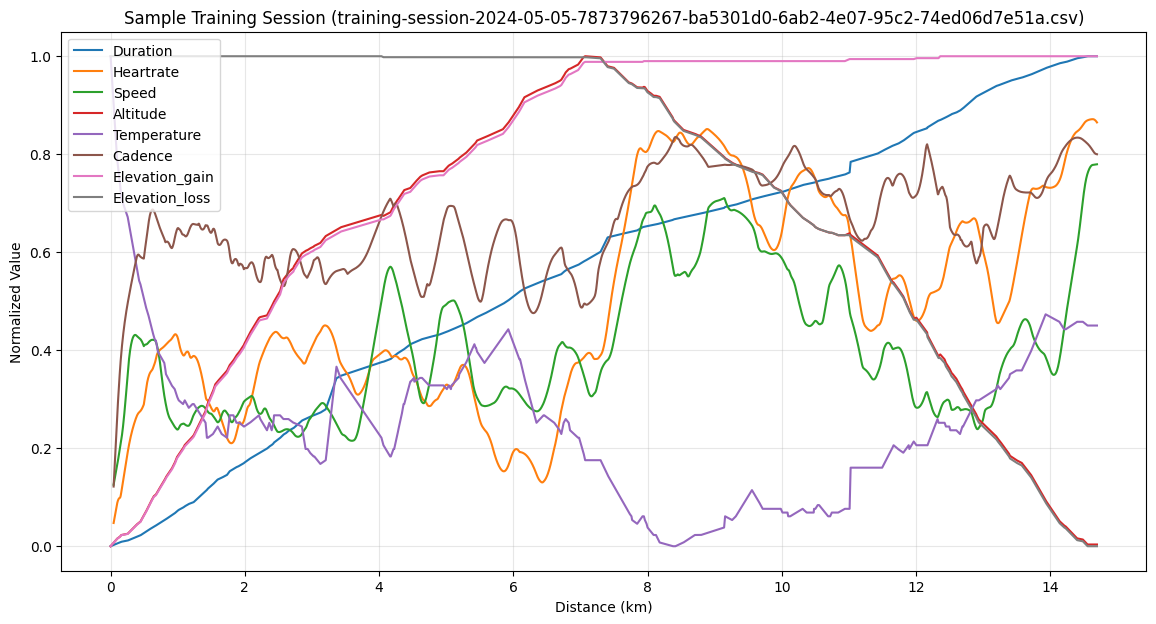

(<Figure size 1400x700 with 1 Axes>,
 <Axes: title={'center': 'Sample Training Session (training-session-2024-05-05-7873796267-ba5301d0-6ab2-4e07-95c2-74ed06d7e51a.csv)'}, xlabel='Distance (km)', ylabel='Normalized Value'>)

In [3]:
import random
import importlib
import utils.viz
importlib.reload(utils.viz)
from utils.viz import plot_session_overview

# Select a random sample file
random.seed(4242)
sample_file = random.choice(training_files)
sample_path = os.path.join(data_dir, sample_file)
sample_data = pd.read_csv(sample_path)

# Plot session overview using the visualization function
plot_session_overview(
    sample_data=sample_data,
    sample_file=sample_file,
    columns=['duration', 'heartRate', 'speed', 'altitude', 'temperature', 'cadence', 'elevation_gain', 'elevation_loss'],
    smoothing_window=100
)

At a glance, certain correlations between some of the variables can be observed. We expect the TFT model will then select the most appropriate variables for the case.

### DataModule

The `TFTDataModule` class was implemented using PyTorch Lightning’s `LightningDataModule` and the `TimeSeriesDataSet` class from the `pytorch-forecasting` library, which is specifically designed for time series modeling.

#### Data Loading

The module loads data automatically. The `prepare_data` function reads all available data and performs necessary preprocessing steps to integrate it with `pytorch-forecasting` components. For example, session identifiers are added as a categorical variable, and distance values are converted into a sequential `time_idx`, which is required by `TimeSeriesDataSet`.

#### Data Splitting

Initially, the data was split temporally into 70:15:15 proportions for training, validation, and test sets, respectively, following standard best practices for time series to prevent data leakage from future to past during validation and testing. However, since the project’s goal is to enable the model to handle *cold-start* scenarios (i.e., predicting before the athlete has even begun the route), the split was instead performed by session rather than by time, using a 75:15:10 ratio to provide slightly more context for training.

The DataModule implementation also includes:

- **Group-wise normalization**: Applies a `GroupNormalizer` per session to improve generalization.  
- **Future covariates handling**: Distinguishes between known and unknown future variables.

**Key configurable parameters:**
- `max_encoder_length`: Maximum encoder length (20 steps)  
- `max_prediction_length`: Prediction horizon (200 steps)  
- `batch_size`: Training batch size (64)  
- `target`: Target variable(s) to predict (`duration_diff`, `heart_rate`, `temperature`, `cadence`)

**Known future-dependent variables** (available at prediction time):  
- `altitude`: Altitude  
- `elevation_diff`: Elevation difference  
- `elevation_gain`: Cumulative elevation gain  
- `elevation_loss`: Cumulative elevation loss  
- `distance`: Distance covered  

**Unknown future-dependent variables:**  
- `duration_diff`: Interval duration  
- `heartRate`: Heart rate  
- `temperature`: Temperature  
- `cadence`: Cadence  
- `speed`: Speed  

The underlying hypothesis is that, when provided with appropriate contextual information about the terrain and route, the Temporal Fusion Transformer (TFT) model will be able to generate highly accurate predictions of race completion time.

In [4]:
# Import the TFT DataModule
# import sys
# sys.path.append('./utils')
from lib.data import TFTDataModule

# Create and setup the TFT data module
data_module = TFTDataModule(
    data_dir="./data/resampled",
    min_encoder_length=1,
    max_encoder_length=400,
    max_prediction_length=200,
    batch_size=64,
    num_workers=2,
)

# Setup the data
data_module.setup()


Loading 101 training session files...
Loaded 101 sessions with 453667 total data points
Minimum required sequence length: 600
Valid sessions: 101/101
Loaded 101 sessions with 453667 total data points
Minimum required sequence length: 600
Valid sessions: 101/101
Session-based splits:
Train sessions: 75, Val sessions: 15, Test sessions: 11
Train data points: 337280, Val: 74662, Test: 41725
Overlap between train-val: 0, train-test: 0
Time-varying known reals: ['altitude', 'elevation_diff', 'elevation_gain', 'elevation_loss']
Time-varying unknown reals: ['duration_diff', 'heartRate', 'temperature', 'cadence', 'speed', 'avg_heart_rate_so_far', 'duration']
Targets: ['duration_diff', 'heartRate', 'temperature', 'cadence']
Session-based splits:
Train sessions: 75, Val sessions: 15, Test sessions: 11
Train data points: 337280, Val: 74662, Test: 41725
Overlap between train-val: 0, train-test: 0
Time-varying known reals: ['altitude', 'elevation_diff', 'elevation_gain', 'elevation_loss']
Time-vary

In [5]:
# Get a sample batch to understand the data structure
train_loader = data_module.train_dataloader()
sample_batch = next(iter(train_loader))

print(f"\nBatch structure:")
print(f"Batch type: {type(sample_batch)}")
print(f"Input features shape: {sample_batch[0]['encoder_cont'].shape}")  # [batch_size, encoder_length, features]
print(f"Target length: {len(sample_batch[1][0])}")          # Number of target variables
print(f"Target variable shape: {sample_batch[1][0][2].shape}")    # [batch_size, prediction_length]


Batch structure:
Batch type: <class 'tuple'>
Input features shape: torch.Size([64, 400, 21])
Target length: 4
Target variable shape: torch.Size([64, 200])


## Modelo

### Temporal Fusion Transformer (TFT)

The **Temporal Fusion Transformer** (TFT) is a deep learning model specifically designed for time series forecasting that can handle both known and unknown future variables.

Initially, a custom architecture was implemented within the `TrailRunningTFT` class, focused on predicting race time for trail running activities, structured as a *PyTorch Lightning* module. This involved instantiating the `TemporalFusionTransformer` model from the `pytorch-forecasting` library inside the custom class. However, since the `TemporalFusionTransformer` class is already implemented as a native *PyTorch Lightning* module, this extra wrapping proved unnecessary. Instead, the approach was revised to directly extend the existing `TemporalFusionTransformer` class, allowing domain-specific customizations tailored to trail running activities.

**Model characteristics:**
- **Architecture**: Based on the Temporal Fusion Transformer, optimized for sequential (time series) data  
- **Known future variables**: `altitude`, `elevation_diff`, `elevation_gain`, `elevation_loss`, `distance_diff` (available at prediction time)  
- **Unknown future variables**: `duration`, `heartRate`, `temperature`, `cadence`, `speed`  
- **Target variables**: `duration`, `heartRate`, `temperature`, `cadence`, `speed`  
- **Input sequence length**: 1–20 time steps  
- **Prediction horizon**: 200 steps into the future

## Finding optimal learning rate



Loading 101 training session files...


Loaded 101 sessions with 453667 total data points
Minimum required sequence length: 600
Valid sessions: 101/101
Session-based splits:
Train sessions: 75, Val sessions: 15, Test sessions: 11
Train data points: 337280, Val: 74662, Test: 41725
Overlap between train-val: 0, train-test: 0
Time-varying known reals: ['altitude', 'elevation_diff', 'elevation_gain', 'elevation_loss']
Time-varying unknown reals: ['duration_diff', 'heartRate', 'temperature', 'cadence', 'speed', 'avg_heart_rate_so_far', 'duration']
Targets: ['duration_diff', 'heartRate', 'temperature', 'cadence']
Session-based splits:
Train sessions: 75, Val sessions: 15, Test sessions: 11
Train data points: 337280, Val: 74662, Test: 41725
Overlap between train-val: 0, train-test: 0
Time-varying known reals: ['altitude', 'elevation_diff', 'elevation_gain', 'elevation_loss']
Time-varying unknown reals: ['duration_diff', 'heartRate', 'temperature', 'cadence', 'speed', 'avg_heart_rate_so_far', 'duration']
Targets: ['duration_diff', '

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Starting learning rate finder...
This will test different learning rates to find the optimal one.
(Using single GPU to avoid multi-GPU segmentation fault)



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Restoring states from the checkpoint path at /home/eaguayo/DeepLearning/ProyectoFinal/.lr_find_5d4653a3-db88-490e-b58d-1351b32039e8.ckpt
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Restoring states from the checkpoint path at /home/eaguayo/DeepLearning/ProyectoFinal/.lr_find_5d4653a3-db88-490e-b58d-1351b32039e8.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /home/eaguayo/DeepLearning/ProyectoFinal/.lr_find_5d4653a3-db88-490e-b58d-1351b32039e8.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /home/eaguayo/DeepLearning/ProyectoFinal/.lr_find_5d4653a3-db88-490e-b58d-1351b32039e8.ckpt
INFO: Restored all states from the checkpoint at /home/eaguayo/DeepLearning/ProyectoFinal/.lr_find_5d4653a3-db88-490e-


Suggested learning rate: 2.951209226666385e-05



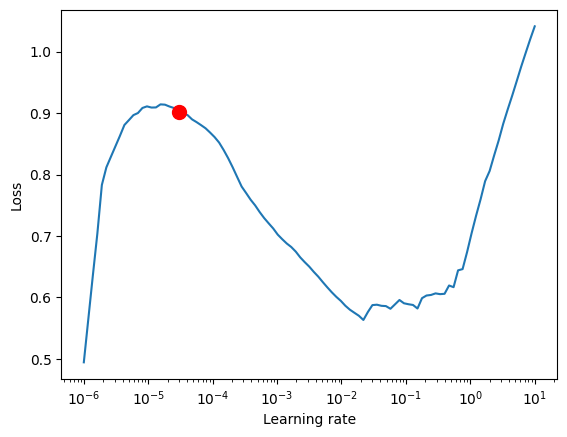

In [6]:
# Find optimal learning rate using PyTorch Lightning Tuner
# NOTE: Using single GPU to avoid SIGSEGV error with multi-GPU distributed strategy
import lightning.pytorch as pl
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.loggers import CSVLogger
from lib.model import TrailRunningTFT

# Create a fresh data module instance for learning rate finder
lr_data_module = TFTDataModule(
    data_dir="./data/resampled",
    min_encoder_length=1,
    max_encoder_length=400,
    max_prediction_length=200,
    batch_size=64,
    num_workers=2,
)

# Setup data
lr_data_module.setup(stage="fit")

# Create model instance for learning rate tuning
# Using same configuration as training.py
tft = TrailRunningTFT.from_dataset(
    lr_data_module.training,
    hidden_size=64,
    learning_rate=0.0005,  # Initial learning rate (will be tuned)
    output_size=[1] * 4,  # Multi-target output: duration_diff, heartRate, temperature, cadence
)

# Create a trainer for learning rate finder
# IMPORTANT: Using single GPU (devices=1) to avoid multi-GPU SIGSEGV error
# The lr_find uses a different training loop that can conflict with distributed strategies
logger = CSVLogger("logs", name="tft_lr_finder")

trainer = pl.Trainer(
    max_epochs=100,  # lr_find will use a subset
    accelerator='auto',
    devices=1,  # Single GPU - avoids SIGSEGV with distributed strategy
    logger=logger,
    gradient_clip_val=0.1,
    enable_checkpointing=False,  # No checkpoints needed for LR finding
    precision="32-true",  # Same as training.py
)

# Run learning rate finder
print("Starting learning rate finder...")
print("This will test different learning rates to find the optimal one.")
print("(Using single GPU to avoid multi-GPU segmentation fault)\n")

tuner = Tuner(trainer)

lr_finder = tuner.lr_find(
    tft,
    train_dataloaders=lr_data_module.train_dataloader(),
    val_dataloaders=lr_data_module.val_dataloader(),
    max_lr=10.0,
    min_lr=1e-6,
    num_training=100,  # Number of learning rate steps to test
)

# Display results
print(f"\n{'='*60}")
print(f"Suggested learning rate: {lr_finder.suggestion()}")
print(f"{'='*60}\n")

# Plot the learning rate finder results
fig = lr_finder.plot(show=True, suggest=True)
fig.show()


## Hyperparmeter optimization

In [7]:
# Hyperparameter Optimization using Optuna
# Running as external script for better resource management

import subprocess
import sys
import os
import pickle

# Path to the hyperparameter optimization script
script_path = "hyperparameter_optimization.py"
output_path = "./optuna_study_broader.pkl"

print("="*80)
print("LAUNCHING HYPERPARAMETER OPTIMIZATION")
print("="*80)
print(f"Script: {script_path}")
print(f"Configuration: 20 trials, max 50 epochs per trial")
print(f"Using single GPU (Optuna's dynamic sampling incompatible with multi-GPU DDP)")
print(f"Output will be saved to: {output_path}")
print("="*80 + "\n")

try:
    execute = False
    if not execute:
        print("Execution flag set to False. Skipping optimization script execution.")
    else:
        # Execute the script with subprocess
        process = subprocess.Popen(
            [sys.executable, script_path],
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            universal_newlines=True,
            bufsize=1
        )
        
        # Display output in real-time
        for line in process.stdout:
            print(line.rstrip())
        
        # Wait for process to complete
        process.wait()
    
    if not execute or (process and process.returncode == 0):
        print("\n" + "="*80)
        print("HYPERPARAMETER OPTIMIZATION COMPLETED SUCCESSFULLY!")
        print("="*80 + "\n")
        
        # Load and display the results
        study_path = "./optuna_study_broader.pkl"
        if os.path.exists(study_path):
            with open(study_path, "rb") as f:
                study = pickle.load(f)
            
            print("Best hyperparameters summary:")
            print("=" * 80)
            for param, value in study.best_trial.params.items():
                print(f"  {param:35}: {value}")
            print("=" * 80)
            print(f"\nBest validation loss: {study.best_trial.value:.6f}")
            print(f"Best trial number: {study.best_trial.number}")
            print(f"Total trials: {len(study.trials)}")
        else:
            print(f"Warning: Could not find {study_path} to load results")
    else:
        print("\n" + "="*80)
        print(f"ERROR: Optimization failed with exit code {process.returncode}")
        print("="*80)

except Exception as e:
    print(f"\nError running optimization script: {str(e)}")
    raise


LAUNCHING HYPERPARAMETER OPTIMIZATION
Script: hyperparameter_optimization.py
Configuration: 20 trials, max 50 epochs per trial
Using single GPU (Optuna's dynamic sampling incompatible with multi-GPU DDP)
Output will be saved to: ./optuna_study_broader.pkl

Execution flag set to False. Skipping optimization script execution.

HYPERPARAMETER OPTIMIZATION COMPLETED SUCCESSFULLY!

Best hyperparameters summary:
  gradient_clip_val                  : 0.04580784428837334
  hidden_size                        : 45
  dropout                            : 0.2571235256601969
  hidden_continuous_size             : 37
  attention_head_size                : 3
  learning_rate                      : 4.3084027772515315e-05

Best validation loss: 12.734667
Best trial number: 0
Total trials: 3


## Training

Training was implemented in a separate script located in the file [training.py](./training.py) to enable standalone execution and optimal resource utilization. Metrics were logged at each epoch to allow monitoring of the training process.

The code below can be used to run training directly within the notebook.

In [8]:
# # Entrenar el modelo
# import subprocess
# import sys

# # Ejecuta el script de entrenamiento usando subprocess
# script_path = "training.py"

# # Verificar que el script existe
# if not os.path.exists(script_path):
#     print(f"Error: No se encontró el archivo {script_path}")
#     exit(1)

# print("Iniciando entrenamiento del modelo TFT...")

# try:
#     # Ejecutar el script con subprocess
#     process = subprocess.Popen(
#         [sys.executable, script_path],
#         stdout=subprocess.PIPE,
#         stderr=subprocess.STDOUT,
#         universal_newlines=True,
#         bufsize=1
#     )
    
#     # Mostrar la salida en tiempo real
#     for line in process.stdout:
#         print(line.rstrip())
    
#     # Esperar a que termine el proceso
#     process.wait()
    
#     if process.returncode == 0:
#         print("Entrenamiento completado exitosamente!")
#     else:
#         print("\n" + "=" * 60)
#         print(f"Error durante el entrenamiento. Código de salida: {process.returncode}")
        
# except Exception as e:
#     print(f"Error al ejecutar el script: {str(e)}")


📊 Hyperparameters for version_5:
learning_rate            : 2.5e-05
dropout                  : 0.25
hidden_size              : 64
hidden_continuous_size   : 32
attention_head_size      : 4
lstm_layers              : 1
max_encoder_length       : 20
max_prediction_length    : 200
min_encoder_length       : 1
weight_decay             : 0.005
causal_attention         : True
optimizer                : adam
reduce_on_plateau_patience: 4
reduce_on_plateau_min_lr : 1.0e-05
reduce_on_plateau_reduction: 2.0
predict_mode             : False
Total Sequence Length    : 220 (20 encoder + 200 prediction)


Plotting metrics for version_5...


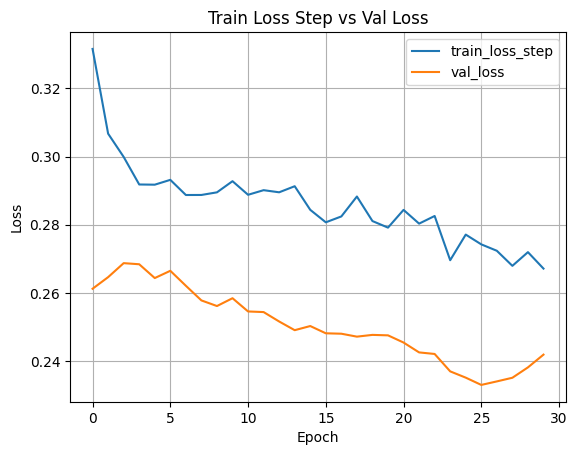


📊 Hyperparameters for version_7:
learning_rate            : 2.5e-05
dropout                  : 0.25
hidden_size              : 64
hidden_continuous_size   : 32
attention_head_size      : 4
lstm_layers              : 1
max_encoder_length       : 200
max_prediction_length    : 200
min_encoder_length       : 1
weight_decay             : 0.005
causal_attention         : True
optimizer                : adam
reduce_on_plateau_patience: 4
reduce_on_plateau_min_lr : 1.0e-05
reduce_on_plateau_reduction: 2.0
predict_mode             : False
Total Sequence Length    : 400 (200 encoder + 200 prediction)


Plotting metrics for version_7...


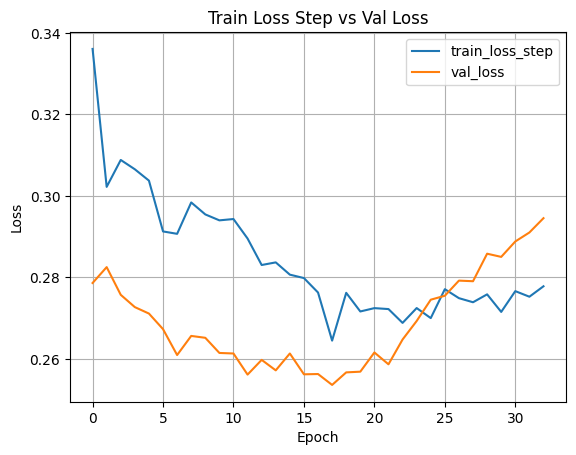


📊 Hyperparameters for version_9:
learning_rate            : 2.5e-05
dropout                  : 0.25
hidden_size              : 32
hidden_continuous_size   : 29
attention_head_size      : 3
lstm_layers              : 1
max_encoder_length       : 200
max_prediction_length    : 200
min_encoder_length       : 1
weight_decay             : 0.0005
causal_attention         : True
optimizer                : adam
reduce_on_plateau_patience: 4
reduce_on_plateau_min_lr : 1.0e-05
reduce_on_plateau_reduction: 2.0
predict_mode             : False
Total Sequence Length    : 400 (200 encoder + 200 prediction)


Plotting metrics for version_9...


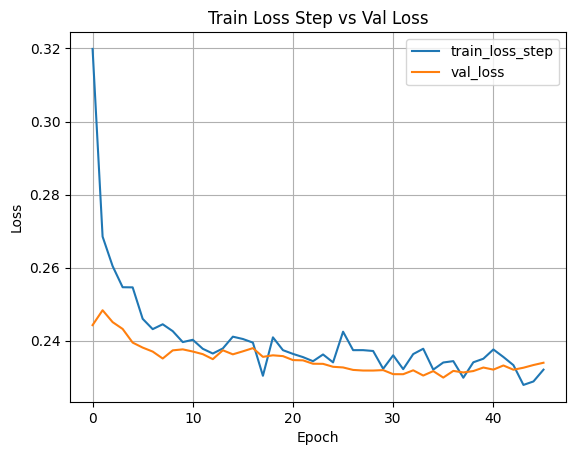


📊 Hyperparameters for version_11:
learning_rate            : 5.0e-05
dropout                  : 0.25
hidden_size              : 63
hidden_continuous_size   : 31
attention_head_size      : 4
lstm_layers              : 1
max_encoder_length       : 200
max_prediction_length    : 200
min_encoder_length       : 1
weight_decay             : 0.0005
causal_attention         : True
optimizer                : adam
reduce_on_plateau_patience: 4
reduce_on_plateau_min_lr : 1.0e-05
reduce_on_plateau_reduction: 2.0
predict_mode             : False
Total Sequence Length    : 400 (200 encoder + 200 prediction)


Plotting metrics for version_11...


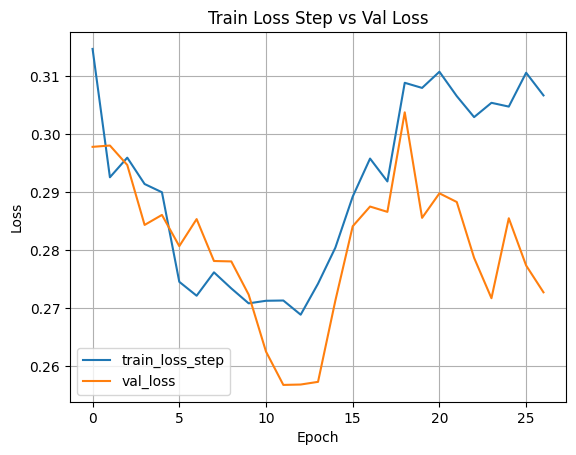


📊 Hyperparameters for version_13:
learning_rate            : 2.5e-05
dropout                  : 0.25
hidden_size              : 41
hidden_continuous_size   : 35
attention_head_size      : 4
lstm_layers              : 1
max_encoder_length       : 200
max_prediction_length    : 200
min_encoder_length       : 1
weight_decay             : 0.0005
causal_attention         : True
optimizer                : adam
reduce_on_plateau_patience: 4
reduce_on_plateau_min_lr : 1.0e-05
reduce_on_plateau_reduction: 2.0
predict_mode             : False
Total Sequence Length    : 400 (200 encoder + 200 prediction)


Plotting metrics for version_13...


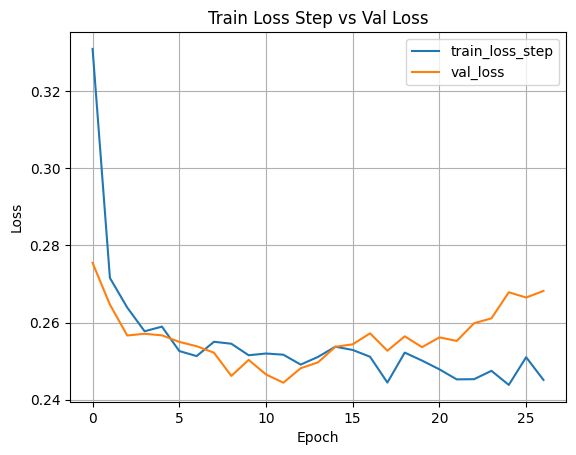


📊 Hyperparameters for version_16:
learning_rate            : 5.0e-05
dropout                  : 0.3
hidden_size              : 71
hidden_continuous_size   : 23
attention_head_size      : 4
lstm_layers              : 1
max_encoder_length       : 200
max_prediction_length    : 200
min_encoder_length       : 1
weight_decay             : 0.0005
causal_attention         : True
optimizer                : adam
reduce_on_plateau_patience: 4
reduce_on_plateau_min_lr : 1.0e-05
reduce_on_plateau_reduction: 2.0
predict_mode             : False
Total Sequence Length    : 400 (200 encoder + 200 prediction)


Plotting metrics for version_16...


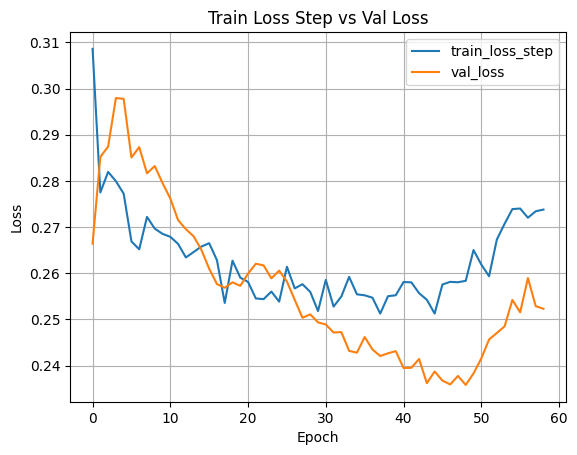


📊 Hyperparameters for version_18:
learning_rate            : 4.0e-05
dropout                  : 0.25
hidden_size              : 45
hidden_continuous_size   : 37
attention_head_size      : 3
lstm_layers              : 1
max_encoder_length       : 400
max_prediction_length    : 200
min_encoder_length       : 1
weight_decay             : 0.0005
causal_attention         : True
optimizer                : adam
reduce_on_plateau_patience: 4
reduce_on_plateau_min_lr : 1.0e-05
reduce_on_plateau_reduction: 2.0
predict_mode             : False
Total Sequence Length    : 600 (400 encoder + 200 prediction)


Plotting metrics for version_18...


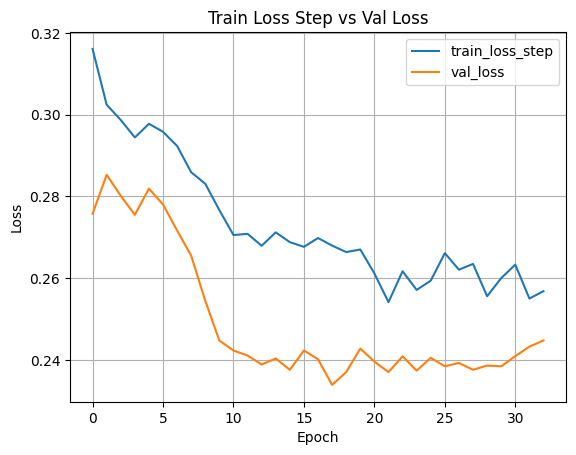

In [9]:
import os
import importlib
# reload utils.viz to ensure latest changes are used
import utils.viz
importlib.reload(utils.viz)
from utils.viz import plot_metrics, extract_hparams

# Plot training and validation loss and extract hyperparameters
logs_dir = "./logs/tft_model/"
for version in ['version_5', 'version_7', 'version_9', 'version_11', 'version_13', 'version_16', 'version_18']:
    version_path = os.path.join(logs_dir, version)
    if not os.path.isdir(version_path):
        continue
    metrics_file = os.path.join(version_path, "metrics.csv")
    hparams_file = os.path.join(version_path, "hparams.yaml")
    
    # Extract and display hyperparameters (if they exist)
    if os.path.exists(hparams_file):
        print(f"\n📊 Hyperparameters for {version}:")
        print("=" * 50)
        
        try:
            params = extract_hparams(hparams_file)
            
            # Define the parameters we're interested in
            key_params = [
                'learning_rate',
                'dropout',
                'hidden_size',
                'hidden_continuous_size',
                'attention_head_size',
                'lstm_layers',
                'max_encoder_length',
                'max_prediction_length',
                'min_encoder_length',
                'weight_decay',
                'causal_attention',
                'optimizer',
                'reduce_on_plateau_patience',
                'reduce_on_plateau_min_lr',
                'reduce_on_plateau_reduction',
                'randomize_length',
                'predict_mode',
            ]
            
            # Display found parameters
            for param in key_params:
                if param in params:
                    print(f"{param:25}: {params[param]}")
            
            # Calculate and display total sequence length
            encoder_len = params.get('max_encoder_length', 'N/A')
            pred_len = params.get('max_prediction_length', 'N/A')
            if isinstance(encoder_len, int) and isinstance(pred_len, int):
                total_len = encoder_len + pred_len
                print(f"{'Total Sequence Length':25}: {total_len} ({encoder_len} encoder + {pred_len} prediction)")
            
            # Display target variables
            if 'target_variables' in params:
                print(f"{'target_variables':25}: {', '.join(params['target_variables'])}")
            
        except Exception as e:
            print(f"Error processing {hparams_file}: {str(e)}")
        
        print("\n" + "=" * 50 + "\n")

    if os.path.exists(metrics_file):
        print(f"Plotting metrics for {version}...")
        plot_metrics(
            metrics_file,
            plot_metrics=[["train_loss_step", "val_loss"]],
            # save_svg_path=os.path.join("./assets/", f"loss_plot_{version}.svg")
        )

## Overfitting Analysis

One of the main objectives was to reduce overfitting while preserving the model’s predictive capability. Analysis of metrics from initial training runs revealed clear signs of overfitting. Several potential causes were identified:

### Dataset Size and Diversity vs. Model Complexity

The primary issue was the limited number of samples, driven by two factors: (1) filtering for relatively long training sessions capable of capturing endurance-related physiological patterns, and (2) intentionally restricting dataset size to accelerate training. At the same time, the model was configured to process long sequence lengths to capture dependencies over larger time windows. However, this increased the number of trainable parameters, making the model overly complex relative to the available data.

Another issue is that many sessions were conducted under varying conditions unknown to the model, including:
- No distinction between training and competition sessions. The Rate of Perceived Exertion (RPE) differs significantly: long training sessions typically maintain an RPE of 3–4, with brief intervals at RPE 5–8, whereas competitions predominantly operate at RPE 5–8, with recovery periods at RPE 2–4.  
- Lack of information on caloric intake, hydration, or ergogenic aids, all of which can significantly impact athletic performance.

A future improvement will involve expanding the dataset with more samples and enriching it with additional metadata such as RPE labels.

### Data Imbalance

An initial configuration used `predict=True` in `TimeSeriesDataSet.from_dataset()` for the validation set, which generated only **one sample per session** for validation. While this initially seemed reasonable, given that the data split was session-based, it created a significant imbalance when compared to the much larger number of training samples produced by the training dataloader. After reviewing the library documentation (https://pytorch-forecasting.readthedocs.io/en/v1.4.0/api/pytorch_forecasting.data.timeseries._timeseries.TimeSeriesDataSet.html#pytorch_forecasting.data.timeseries._timeseries.TimeSeriesDataSet.from_dataset), it became clear that this parameter controls whether only the final sequence per series is used (`predict=True`) or multiple subsequences are generated (`predict=False`). The setting was changed to `predict=False` to obtain multiple validation samples per session, ensuring a more balanced evaluation.

### Excessively Long Sequences

The model was initially configured with an encoder length of 250 steps plus a prediction horizon of 50 steps (300 total steps), aiming to capture long-range temporal dependencies relevant to endurance activities. However, this made the model too complex for the dataset size. Various encoder/prediction length combinations were tested without significant improvement. Ultimately, the configuration was reduced to an encoder length of 200 steps and a prediction horizon of 40 steps (240 total steps).

### Insufficient Regularization

Initially, sequence lengths were not randomized, dropout was low (0.1), and `weight_decay` was not enabled for regularization. To address this, `randomize_length=True` was activated, dropout was increased to 0.3, and `weight_decay` was added to the optimizer.

### Complex Multi-Target Prediction

The model simultaneously predicts 5 target variables using 21 input features. To handle the varying scales and importance of these targets, a weighted loss function was implemented as a solution.

## Initial model (V1) latest trial evaluation

In [10]:
import torch
import numpy as np
import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger
from training import find_latest_checkpoint
from lib.model import TrailRunningTFT
from lib.data import TFTDataModule

# Create and setup the TFT data module
data_module = TFTDataModule(
    data_dir="./data/resampled",
    min_encoder_length=1,
    max_encoder_length=400,
    max_prediction_length=200,
    batch_size=64,
    num_workers=2,
)

# Setup the data
data_module.setup()

# Evaluate the model
logger = CSVLogger(
    save_dir="./logs/tft_model/",
    name="tft_evaluation",
    version=0
)

# Load the trainer on the latest checkpoint
trainer = pl.Trainer(
    max_epochs=1,
    accelerator='auto',
    strategy='auto',
    logger=logger,
    devices='auto',
    enable_checkpointing=True,
    precision="32-true",
    callbacks=[]
)

model = TrailRunningTFT.from_dataset(
    data_module.test,
    hidden_size=45,
    learning_rate=0.001,
    output_size=[1] * 4, # Multi-target output 
)

ckpt_path = find_latest_checkpoint()
if (not ckpt_path):
    print("No checkpoint found, cannot evaluate model.")
    exit(1)

print(f"Cargando modelo desde checkpoint: {ckpt_path}")

# Test the model on test dataset
test_results = trainer.test(model, data_module.test_dataloader(), ckpt_path=ckpt_path)


INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Loading 101 training session files...
Loaded 101 sessions with 453667 total data points
Minimum required sequence length: 600
Valid sessions: 101/101
Loaded 101 sessions with 453667 total data points
Minimum required sequence length: 600
Valid sessions: 101/101
Session-based splits:
Train sessions: 75, Val sessions: 15, Test sessions: 11
Train data points: 337280, Val: 74662, Test: 41725
Overlap between train-val: 0, train-test: 0
Time-varying known reals: ['altitude', 'elevation_diff', 'elevation_gain', 'elevation_loss']
Time-varying unknown reals: ['duration_diff', 'heartRate', 'temperature', 'cadence', 'speed', 'avg_heart_rate_so_far', 'duration']
Targets: ['duration_diff', 'heartRate', 'temperature', 'cadence']
Session-based splits:
Train sessions: 75, Val sessions: 15, Test sessions: 11
Train data points: 337280, Val: 74662, Test: 41725
Overlap between train-val: 0, train-test: 0
Time-varying known reals: ['altitude', 'elevation_diff', 'elevation_gain', 'elevation_loss']
Time-vary

INFO: Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheck

Training samples: 352205
Validation samples: 77647
Test samples: 11

=== Using Standard SMAPE Loss ===
Target weights:
  duration_diff: 85.0%
  heartRate: 5.0%
  temperature: 5.0%
  cadence: 5.0%


INFO: Restoring states from the checkpoint path at ./checkpoints/best-checkpoint-epoch=17-val_loss=0.23.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at ./checkpoints/best-checkpoint-epoch=17-val_loss=0.23.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at ./checkpoints/best-checkpoint-epoch=17-val_loss=0.23.ckpt


Cargando modelo desde checkpoint: ./checkpoints/best-checkpoint-epoch=17-val_loss=0.23.ckpt


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO: Loaded model weights from the checkpoint at ./checkpoints/best-checkpoint-epoch=17-val_loss=0.23.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at ./checkpoints/best-checkpoint-epoch=17-val_loss=0.23.ckpt
INFO: Loaded model weights from the checkpoint at ./checkpoints/best-checkpoint-epoch=17-val_loss=0.23.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at ./checkpoints/best-checkpoint-epoch=17-val_loss=0.23.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     cadence test_MAE      │    4.2775397300720215     │
│     cadence test_RMSE     │     6.30612850189209      │
│    cadence test_SMAPE     │    0.05505767837166786    │
│  duration_diff test_MAE   │    0.6291716694831848     │
│  duration_diff test_RMSE  │    0.9269328117370605     │
│ duration_diff test_SMAPE  │    0.4518342614173889     │
│    heartRate test_MAE     │    18.682706832885742     │
│    heartRate test_RMSE    │       20.6123046875       │
│   heartRate test_SMAPE    │    0.13618212938308716    │
│   temperature test_MAE    │     4.840836048126221     │
│   temperature test_RMSE   │     5.212912559509277     │
│  temperature test_SMAPE   │    0.2872926592826843     │
│         test_loss         │    0.40798577666282654    │
└───────────────────────────┴───────────────────────────┘

## Single Batch Sample Visualization

INFO: Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installi

tensor([400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400])
=== Visualizing Duration (Target 0) for Batch 0 ===


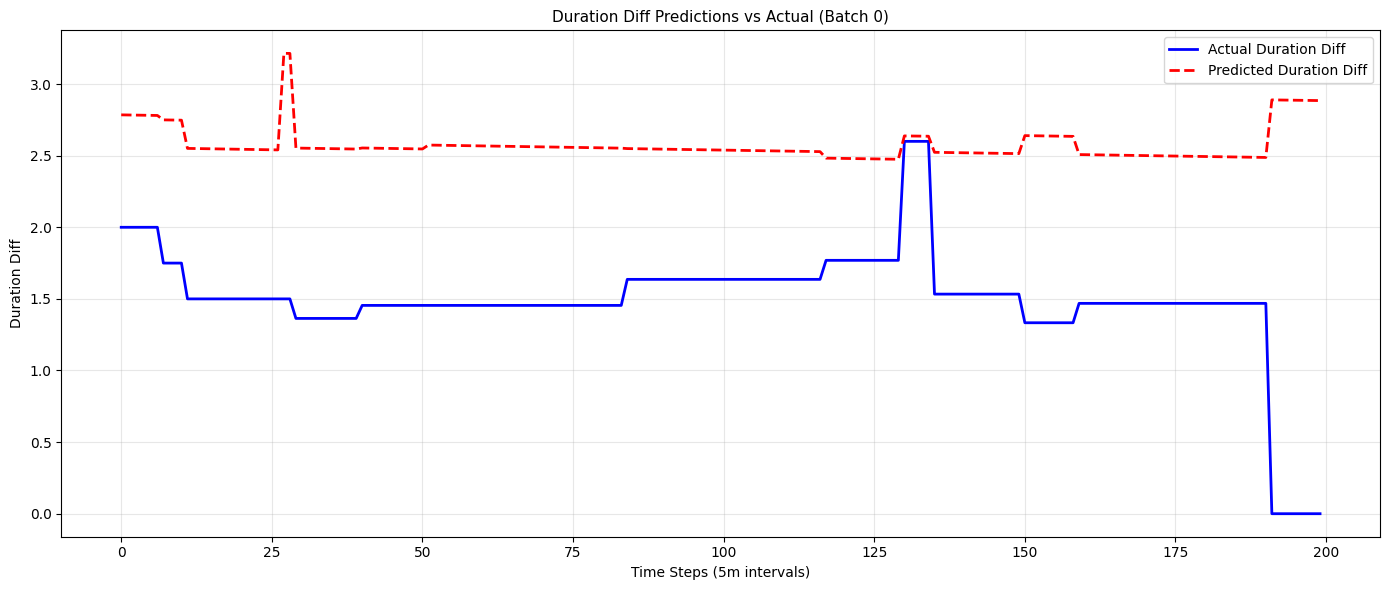


Error Metrics for Duration Diff (Batch 0)
Session ID (encoded): 75

MSE:  1.3656
MAE:  1.0797
RMSE: 1.1686
MAPE: 65.87%


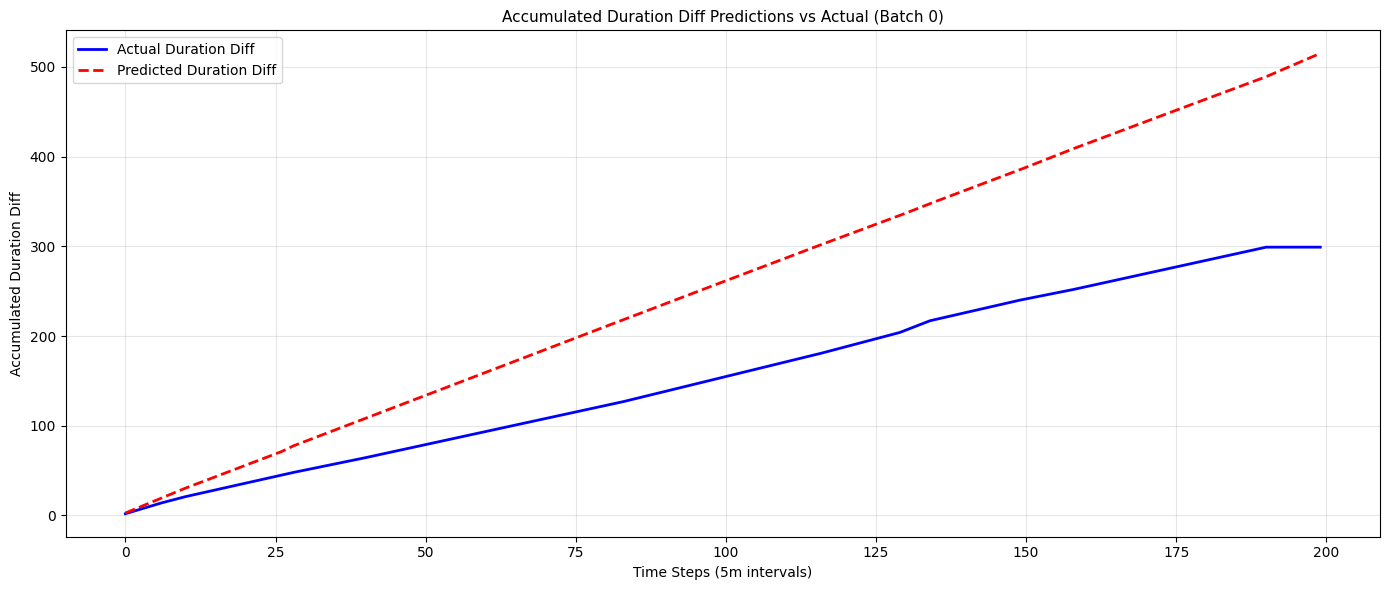


Error Metrics for Duration Diff (Batch 0)
Session ID (encoded): 75

MSE:  1.3656
MAE:  1.0797
RMSE: 1.1686
MAPE: 65.87%

Accumulated Totals:
Actual Total: 299.00
Predicted Total: 514.95
Absolute Difference: 215.95
Percentage Difference: 72.22%

=== Visualizing Heart Rate (Target 1) for Batch 0 ===


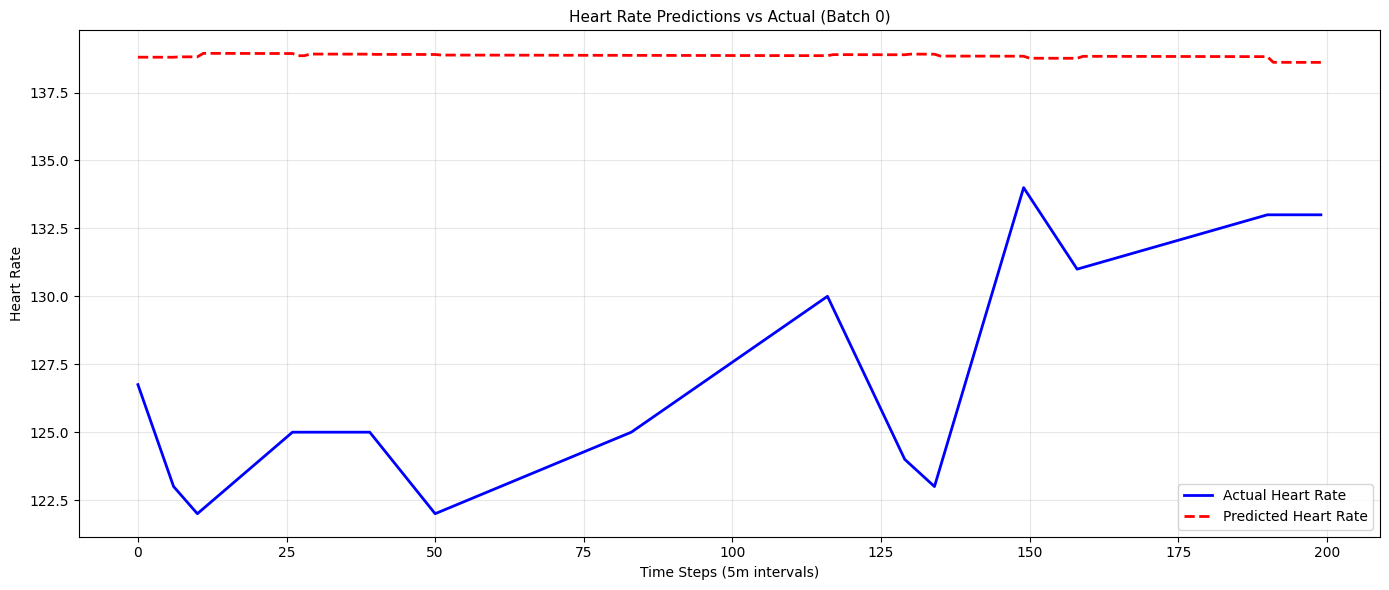


Error Metrics for Heart Rate (Batch 0)
Session ID (encoded): 75

MSE:  152.0129
MAE:  11.7462
RMSE: 12.3294
MAPE: 9.33%

=== Visualizing Duration (Target 0) for Batch 1 ===


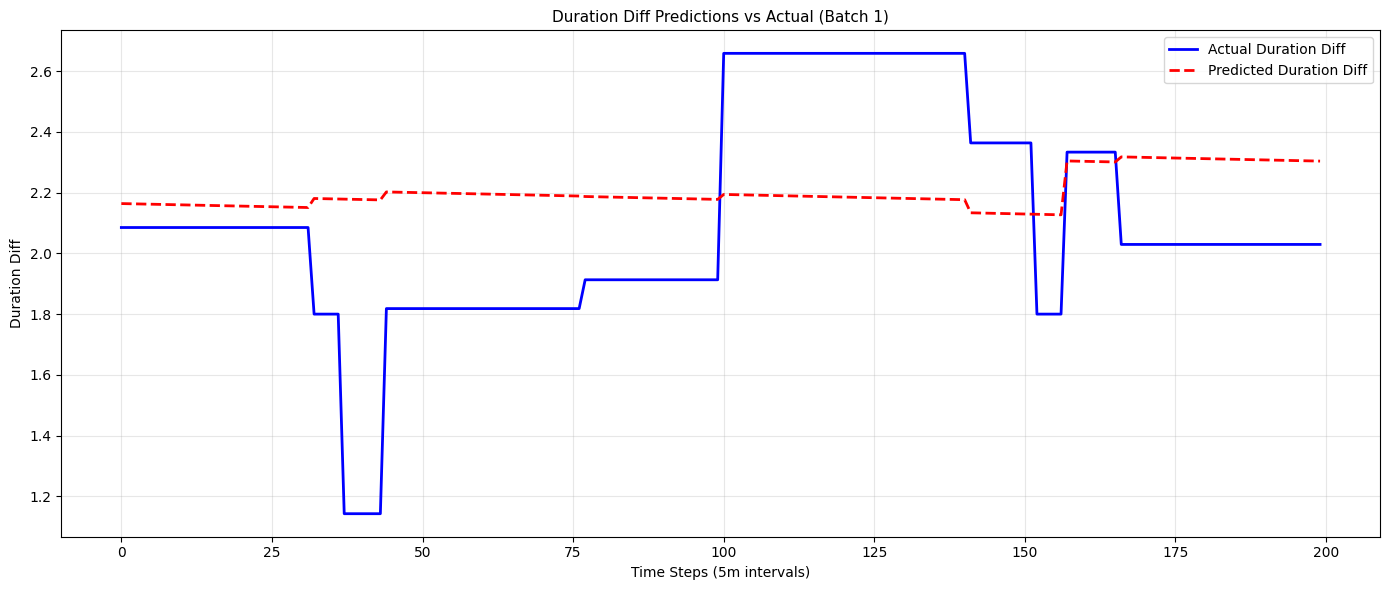


Error Metrics for Duration Diff (Batch 1)

MSE:  0.1388
MAE:  0.3177
RMSE: 0.3726
MAPE: 16.35%


In [11]:
import importlib
import utils.viz
importlib.reload(utils.viz)
from utils.viz import visualize_predictions

raw_predictions = model.predict(
    data_module.test_dataloader(), mode="raw", return_x=True
)
# print(raw_predictions.x.keys())
print(raw_predictions.x['encoder_lengths'])

# Visualize duration for batch 0
print("=== Visualizing Duration (Target 0) for Batch 0 ===")
pred_duration, act_duration = visualize_predictions(raw_predictions, batch_id=0, target_idx=0, target_name="Duration Diff")
pred_duration, act_duration = visualize_predictions(raw_predictions, batch_id=0, target_idx=0, target_name="Duration Diff", show_accumulated=True)

# Visualize heart rate for batch 0
print("\n=== Visualizing Heart Rate (Target 1) for Batch 0 ===")
pred_hr, act_hr = visualize_predictions(raw_predictions, batch_id=0, target_idx=1, target_name="Heart Rate")

# If you have multiple batches, visualize a different batch
print("\n=== Visualizing Duration (Target 0) for Batch 1 ===")
try:
    pred_duration_b1, act_duration_b1 = visualize_predictions(raw_predictions, batch_id=1, target_idx=0, target_name="Duration Diff")
except IndexError:
    print("Batch 1 not available (only 1 batch in dataset)")

## Full cold-start inference for an entire session

Performs sequential cold-start inference on the first test session:
1. Uses synthetic encoder (weighted avg of historical first samples) with encoder_length=1
2. Predicts max_prediction_length (200) steps using known terrain data
3. Uses predicted values to create encoder for next chunk
4. Repeats until entire session is predicted
5. Visualizes accumulated duration error throughout

In [12]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer
from pytorch_forecasting.data.encoders import NaNLabelEncoder
import warnings
warnings.filterwarnings("ignore")

# Reload modules for latest changes
import importlib
import lib.data
import lib.model
importlib.reload(lib.data)
importlib.reload(lib.model)
from lib.data import TFTDataModule, calculate_weighted_first_sample
from lib.model import TrailRunningTFT
from training import find_latest_checkpoint

# =============================================================================
# CONFIGURATION
# =============================================================================
ENCODER_LENGTH = 1  # Cold-start: minimal encoder
MAX_PREDICTION_LENGTH = 200  # Steps to predict per chunk
MAX_ENCODER_LENGTH = 400  # For dataset configuration

print("="*80)
print("COLD-START SEQUENTIAL INFERENCE")
print("="*80)
print(f"Encoder Length: {ENCODER_LENGTH}")
print(f"Prediction Length per chunk: {MAX_PREDICTION_LENGTH}")
print("="*80)

# =============================================================================
# SETUP DATA MODULE AND MODEL
# =============================================================================
# Create data module (without sliding windows for raw data access)
data_module = TFTDataModule(
    data_dir="./data/resampled",
    min_encoder_length=ENCODER_LENGTH,
    max_encoder_length=MAX_ENCODER_LENGTH,
    max_prediction_length=MAX_PREDICTION_LENGTH,
    batch_size=1,  # Single sample for inference
    num_workers=0,
    use_sliding_windows=False
)
data_module.setup()

# Load checkpoint
ckpt_path = find_latest_checkpoint()
if not ckpt_path:
    raise RuntimeError("No checkpoint found!")
print(f"\nLoading model from: {ckpt_path}")

# Load model - use CPU for inference to avoid device issues
model = TrailRunningTFT.load_from_checkpoint(ckpt_path, map_location='cpu')
model.eval()


COLD-START SEQUENTIAL INFERENCE
Encoder Length: 1
Prediction Length per chunk: 200
Loading 101 training session files...
Loaded 101 sessions with 453667 total data points
Minimum required sequence length: 600
Valid sessions: 101/101
Loaded 101 sessions with 453667 total data points
Minimum required sequence length: 600
Valid sessions: 101/101
Session-based splits:
Train sessions: 75, Val sessions: 15, Test sessions: 11
Train data points: 337280, Val: 74662, Test: 41725
Overlap between train-val: 0, train-test: 0
Time-varying known reals: ['altitude', 'elevation_diff', 'elevation_gain', 'elevation_loss']
Time-varying unknown reals: ['duration_diff', 'heartRate', 'temperature', 'cadence', 'speed', 'avg_heart_rate_so_far', 'duration']
Targets: ['duration_diff', 'heartRate', 'temperature', 'cadence']
Session-based splits:
Train sessions: 75, Val sessions: 15, Test sessions: 11
Train data points: 337280, Val: 74662, Test: 41725
Overlap between train-val: 0, train-test: 0
Time-varying known 

TrailRunningTFT(
  	"attention_head_size":               3
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'time_idx', 'target': ['duration_diff', 'heartRate', 'temperature', 'cadence'], 'group_ids': ['session_id_encoded'], 'weight': None, 'max_encoder_length': 400, 'min_encoder_length': 1, 'min_prediction_idx': 0, 'min_prediction_length': 200, 'max_prediction_length': 200, 'static_categoricals': None, 'static_reals': None, 'time_varying_known_categoricals': None, 'time_varying_known_reals': ['altitude', 'elevation_diff', 'elevation_gain', 'elevation_loss'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['duration_diff', 'heartRate', 'temperature', 'cadence', 'speed', 'avg_heart_rate_so_far', 'duration'], 'variable_groups': None, 'constant_fill_strategy': None, 'allow_missing_timesteps': False, 'lags': None, 'add_relative_time_idx': True, 'add_target_scales': True, 'a

In [13]:
test_session_ids = sorted(data_module.test_data['session_id'].unique())
for session_id in test_session_ids:
    session_length = len(data_module.test_data[data_module.test_data['session_id'] == session_id])
    distance_km = session_length * 5 / 1000  # 5m per step
    print(f"{session_id}: {session_length} steps ({distance_km:.2f} km)")

training-session-2025-02-25-8061276512-5f1e505e-faa9-446e-baca-0af78f90e6b7: 3470 steps (17.35 km)
training-session-2025-03-01-8063894910-3798d23c-94c2-464d-b8b0-05a092cb6652: 3715 steps (18.57 km)
training-session-2025-03-07-8067673091-6f8df649-a05e-486b-a405-7cfac373eea9: 3627 steps (18.14 km)
training-session-2025-03-09-8069229866-675a6a83-bd23-46ca-855a-58106d60ad86: 2899 steps (14.49 km)
training-session-2025-03-13-8071682142-0e6800df-ffe8-4344-a399-0e36467f6d6b: 3414 steps (17.07 km)
training-session-2025-03-16-8073715633-14e5bad2-2106-4d13-a200-5643db7c17e1: 4903 steps (24.52 km)
training-session-2025-03-23-8078233046-62fbec09-969b-4960-b3c0-93a55c17f778: 4475 steps (22.38 km)
training-session-2025-03-28-8083709660-dcd72912-9628-4fbe-82d1-12ec7796237a: 3388 steps (16.94 km)
training-session-2025-04-05-8090858642-183e3db9-8a48-4849-a88a-e79f8db3356d: 3915 steps (19.57 km)
training-session-2025-04-17-8097527167-c71fd6ff-9718-47a2-a948-7ed5eb38990c: 4071 steps (20.36 km)
training-s

In [14]:

# =============================================================================
# V1 MODEL: COLD-START SEQUENTIAL INFERENCE (SMAPE Loss)
# Uses evaluate_full_session_sequential from lib.model
# =============================================================================
from lib.model import evaluate_full_session_sequential

# Configuration
ENCODER_LENGTH = 1        # Cold-start: minimal encoder
MAX_PREDICTION_LENGTH = 200  # Steps to predict per chunk
target_names = ['duration_diff', 'heartRate', 'temperature', 'cadence']

# Select test session
test_session_ids = sorted(data_module.test_data['session_id'].unique())
session_id = test_session_ids[5]

print("="*80)
print("V1 MODEL: COLD-START SEQUENTIAL INFERENCE")
print("="*80)
print(f"Session: {session_id}")
session_data = data_module.test_data[data_module.test_data['session_id'] == session_id]
session_length = len(session_data)
print(f"Session length: {session_length} steps ({session_length * 5 / 1000:.2f} km)")

# Create synthetic encoder for downstream cells
synthetic_encoder = calculate_weighted_first_sample(data_module.train_data)
first_test_session_encoded = session_data['session_id_encoded'].iloc[0]

# Run full session sequential evaluation
result = evaluate_full_session_sequential(
    model=model,
    test_data=data_module.test_data,
    train_data=data_module.train_data,
    session_id=session_id,
    calculate_weighted_first_sample_fn=calculate_weighted_first_sample,
    max_pred_length=MAX_PREDICTION_LENGTH,
    encoder_length=ENCODER_LENGTH,
    verbose=True  # Print chunk-by-chunk progress
)

# Extract results for visualization
all_predictions = result['all_predictions']
all_actuals = result['all_actuals']
chunk_errors = result['chunk_errors']
chunk_boundaries = result['chunk_boundaries']

print("\n" + "="*80)
print("PREDICTION COMPLETE")
print("="*80)
print(f"Total chunks processed: {result['chunks_processed']}")
print(f"Total steps predicted: {result['steps_predicted']}")
print(f"Final error: {result['final_error_pct']:+.1f}%")
print(f"Actual duration: {result['actual_duration_min']:.1f} min")
print(f"Predicted duration: {result['pred_duration_min']:.1f} min")


V1 MODEL: COLD-START SEQUENTIAL INFERENCE
Session: training-session-2025-03-16-8073715633-14e5bad2-2106-4d13-a200-5643db7c17e1
Session length: 4903 steps (24.52 km)
Starting evaluation for session: training-session-2025-03-16-8073715633-14e5bad2-2106-4d13-a200-5643db7c17e1
Session length: 4903 steps

--- Chunk 1 ---
  Prediction range: steps 0 to 199 (200 steps)
  Distance: 0.00 km to 0.99 km

--- Chunk 1 ---
  Prediction range: steps 0 to 199 (200 steps)
  Distance: 0.00 km to 0.99 km
  Predictions obtained: 200 steps
  Chunk MAE (duration_diff): 0.5767

--- Chunk 2 ---
  Prediction range: steps 200 to 399 (200 steps)
  Distance: 1.00 km to 2.00 km
  Predictions obtained: 200 steps
  Chunk MAE (duration_diff): 0.3648

--- Chunk 3 ---
  Prediction range: steps 400 to 599 (200 steps)
  Distance: 2.00 km to 3.00 km
  Predictions obtained: 200 steps
  Chunk MAE (duration_diff): 0.5767

--- Chunk 2 ---
  Prediction range: steps 200 to 399 (200 steps)
  Distance: 1.00 km to 2.00 km
  Predic


Per-Chunk Duration Predictions with Elevation Profile


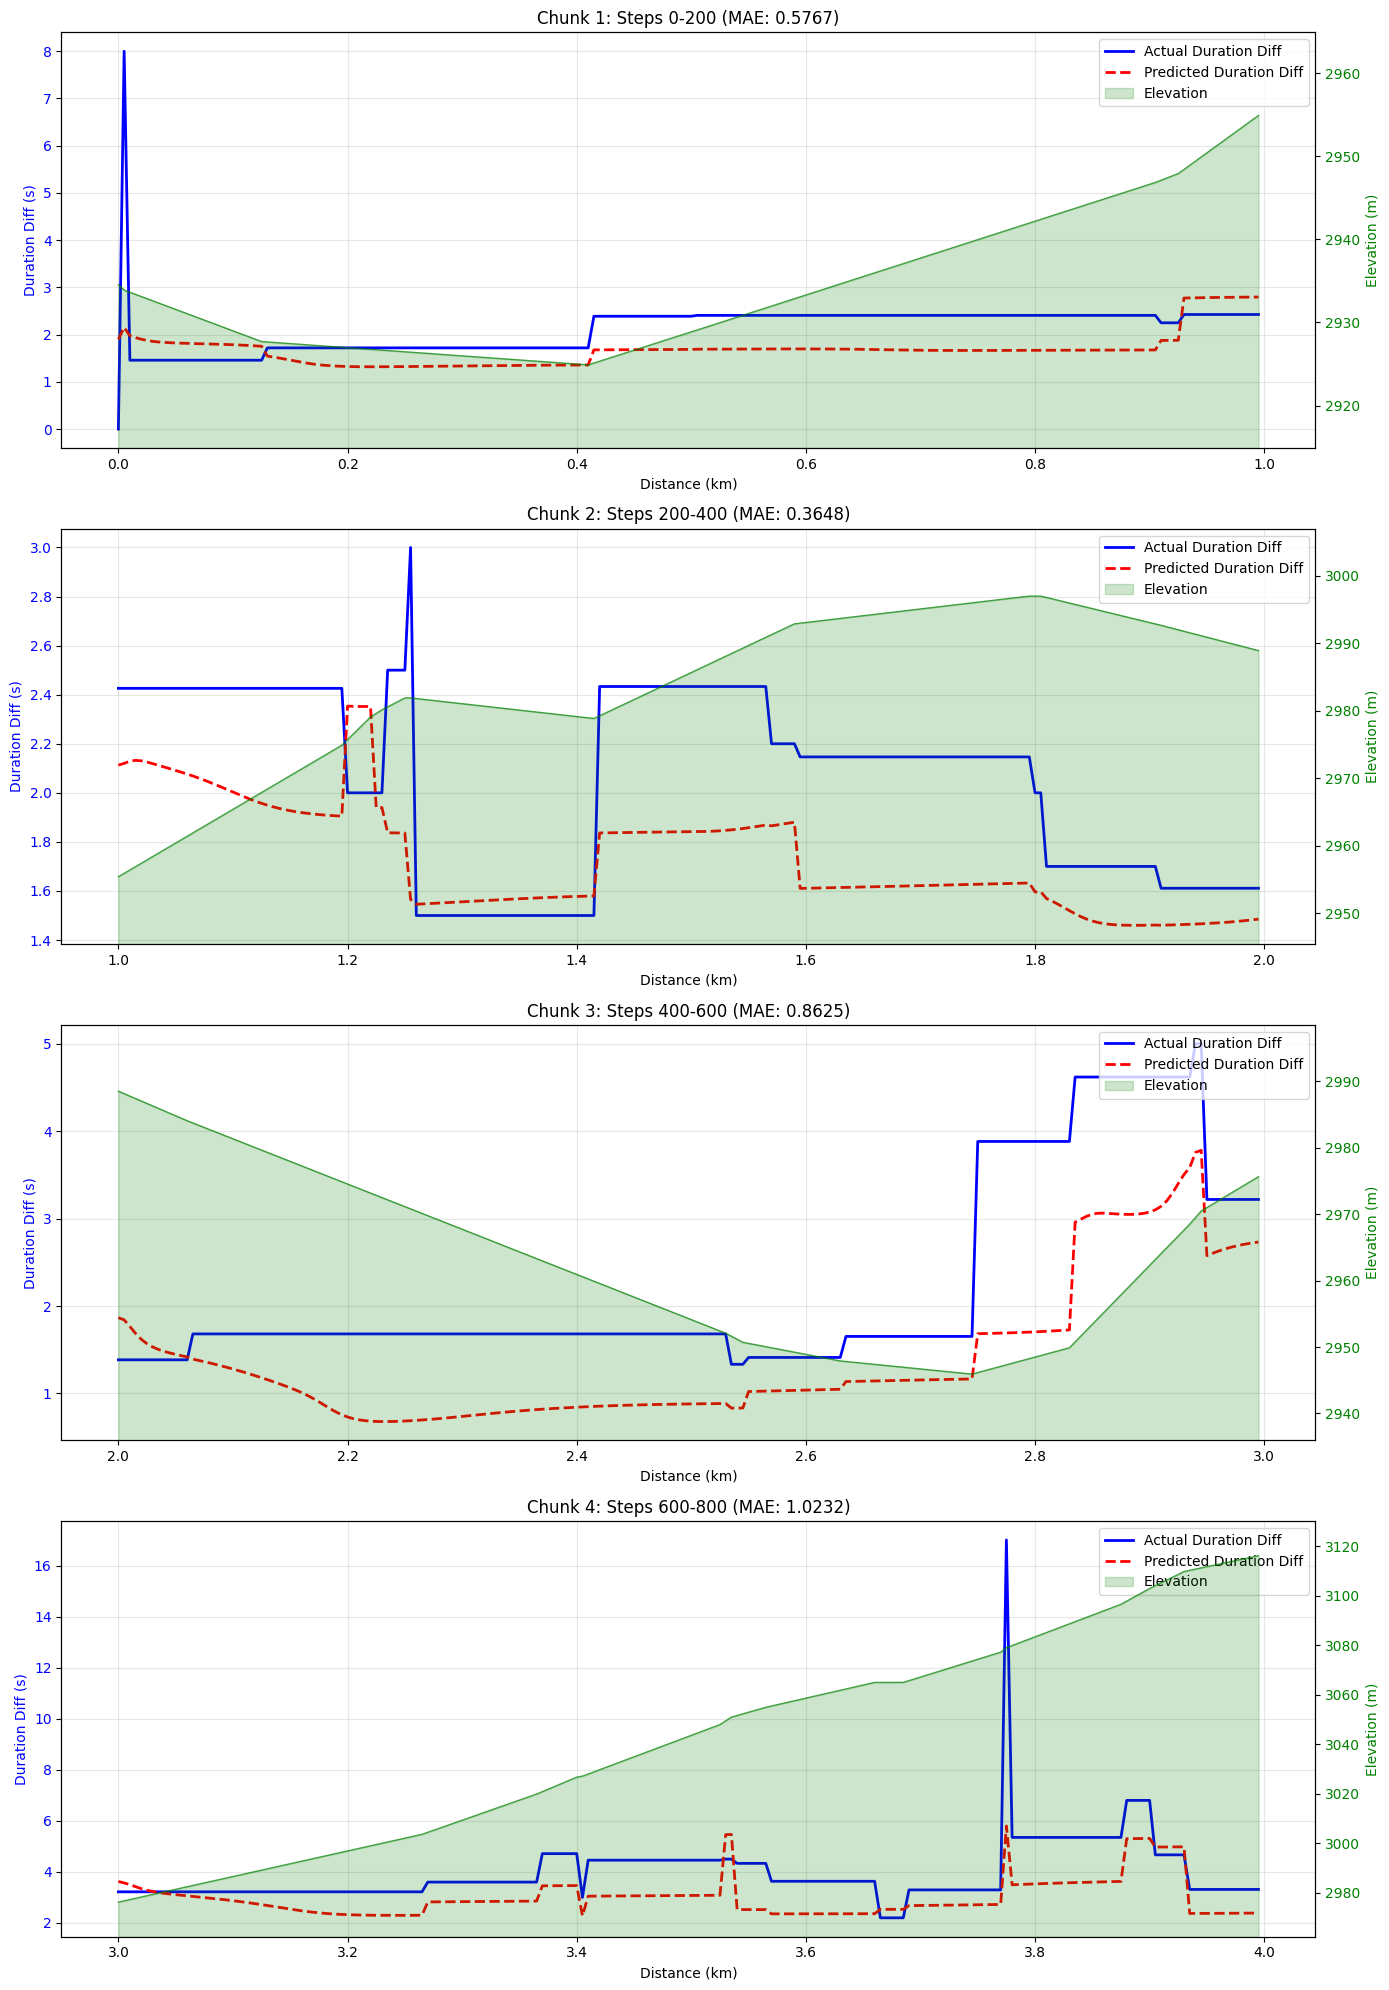


Accumulated Duration Error


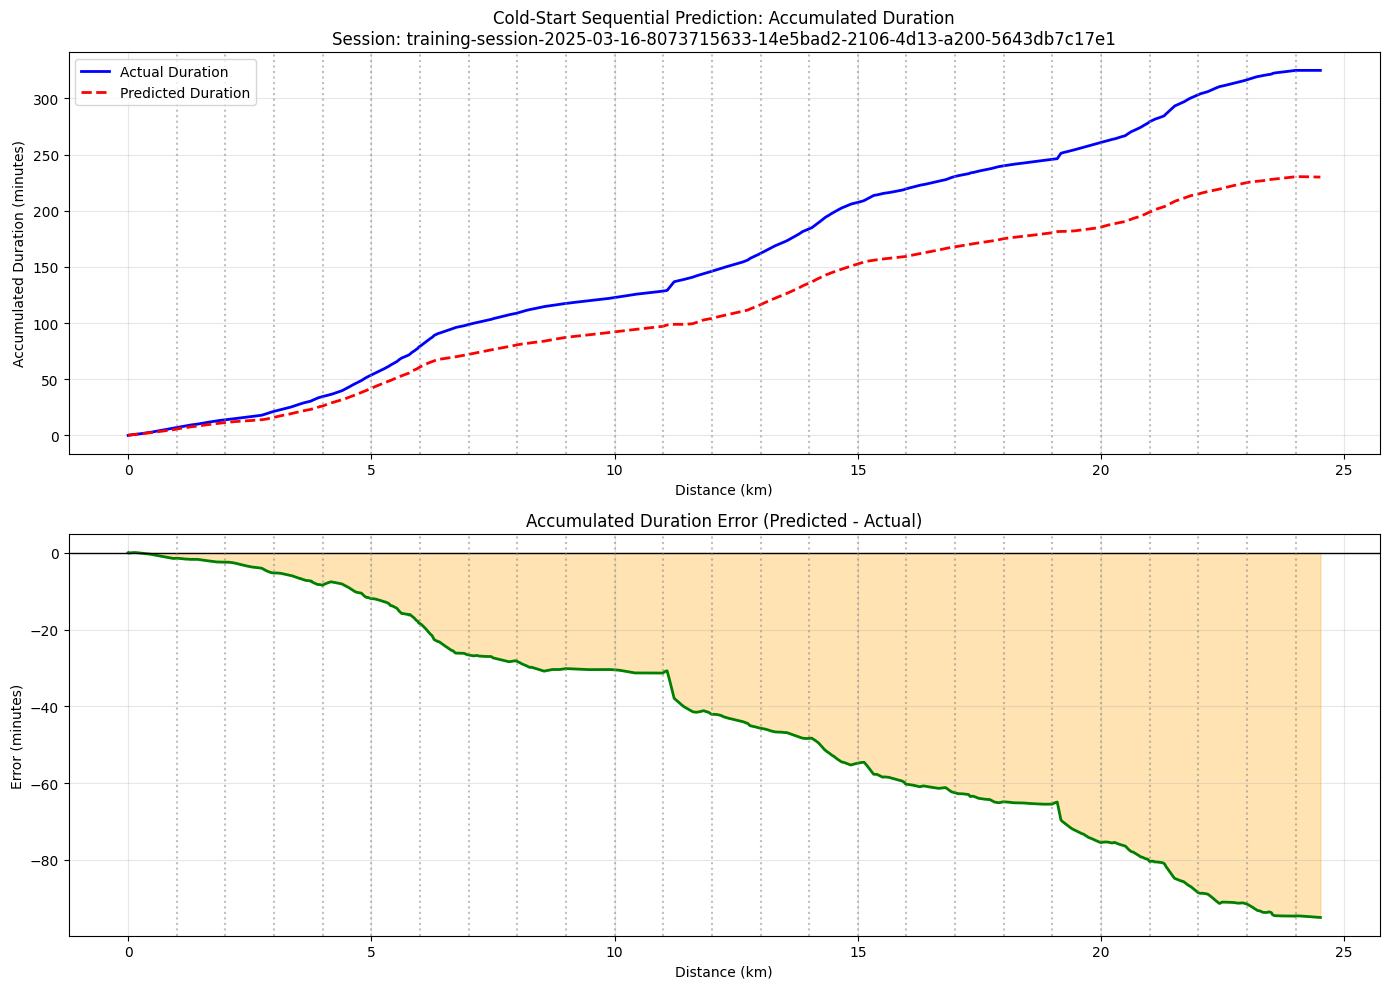


FINAL SUMMARY STATISTICS

Session: training-session-2025-03-16-8073715633-14e5bad2-2106-4d13-a200-5643db7c17e1
Total Distance: 24.51 km
Total Steps Predicted: 4903
Number of Chunks: 25

--- Duration Prediction ---
Actual Total Duration: 324.93 minutes (5.42 hours)
Predicted Total Duration: 229.95 minutes (3.83 hours)
Absolute Error: 94.99 minutes
Percentage Error: 29.23%

--- Per-Chunk MAE (duration_diff) ---
  Chunk 1: MAE = 0.5767
  Chunk 2: MAE = 0.3648
  Chunk 3: MAE = 0.8625
  Chunk 4: MAE = 1.0232
  Chunk 5: MAE = 1.6126
  Chunk 6: MAE = 2.0597
  Chunk 7: MAE = 2.4550
  Chunk 8: MAE = 0.7301
  Chunk 9: MAE = 1.0084
  Chunk 10: MAE = 0.1318
  Chunk 11: MAE = 0.2630
  Chunk 12: MAE = 3.8351
  Chunk 13: MAE = 1.1062
  Chunk 14: MAE = 0.8236
  Chunk 15: MAE = 2.2715
  Chunk 16: MAE = 1.8430
  Chunk 17: MAE = 0.9313
  Chunk 18: MAE = 0.9404
  Chunk 19: MAE = 0.2200
  Chunk 20: MAE = 3.3329
  Chunk 21: MAE = 1.6538
  Chunk 22: MAE = 2.5275
  Chunk 23: MAE = 1.1884
  Chunk 24: MAE = 1.

In [15]:
# =============================================================================
# VISUALIZATION AND SUMMARY
# =============================================================================
import importlib
import utils.viz
import utils.results
importlib.reload(utils.viz)
importlib.reload(utils.results)
from utils.viz import (
    plot_chunk_predictions, 
    plot_accumulated_duration_error
)
from utils.results import (
    print_cold_start_summary,
    save_cold_start_summary
)

if len(chunk_errors) > 0:
    # Plot per-chunk duration predictions
    plot_chunk_predictions(
        all_predictions, all_actuals, chunk_errors, session_data,
        max_chunks=4, save_path='./assets/cold_start_chunks.png'
    )

    # Plot accumulated duration error
    stats = plot_accumulated_duration_error(
        all_predictions, all_actuals, session_data, chunk_boundaries,
        session_id=session_id,
        save_path='./assets/cold_start_accumulated_error.png'
    )

    # Print summary statistics
    summary_stats = print_cold_start_summary(
        all_predictions, chunk_errors, stats, session_id=session_id
    )

    # Save summary to file
    save_cold_start_summary(
        summary_file='./assets/cold_start_inference_summary.md',
        all_predictions=all_predictions,
        chunk_errors=chunk_errors,
        stats=stats,
        summary_stats=summary_stats,
        session_id=session_id,
        encoder_length=ENCODER_LENGTH,
        max_prediction_length=MAX_PREDICTION_LENGTH,
        ckpt_path=ckpt_path
    )
else:
    print("\nNo successful predictions were made. Check error messages above.")

print("="*80)

### Cold Start Preliminary results analysis

We note that Cold Start predictions are generally lower than the actual values. We need to investigate the training data to find the root cause for this under-prediction on cold start.


OVERALL STATISTICS
Mean Predicted duration_diff: 2.8140 seconds/5m
Mean Actual duration_diff:    3.9763 seconds/5m
Mean Error (Pred - Actual):   -1.1624 seconds/5m
Median Error:                 -0.7191 seconds/5m
Std of Errors:                1.9870

BIAS: -29.23% (negative = under-prediction)

PER-CHUNK BIAS ANALYSIS
------------------------------------------------------------
Chunk  1: Bias = -0.4197s (-19.9%) | Pred mean: 1.690 | Actual mean: 2.110
Chunk  2: Bias = -0.3266s (-15.9%) | Pred mean: 1.729 | Actual mean: 2.055
Chunk  3: Bias = -0.8364s (-37.4%) | Pred mean: 1.400 | Actual mean: 2.236
Chunk  4: Bias = -0.9545s (-24.2%) | Pred mean: 2.990 | Actual mean: 3.944
Chunk  5: Bias = -1.0524s (-18.3%) | Pred mean: 4.707 | Actual mean: 5.759
Chunk  6: Bias = -1.9417s (-25.4%) | Pred mean: 5.703 | Actual mean: 7.645
Chunk  7: Bias = -2.4533s (-41.9%) | Pred mean: 3.399 | Actual mean: 5.852
Chunk  8: Bias = -0.4983s (-16.3%) | Pred mean: 2.558 | Actual mean: 3.056
Chunk  9: Bias = -

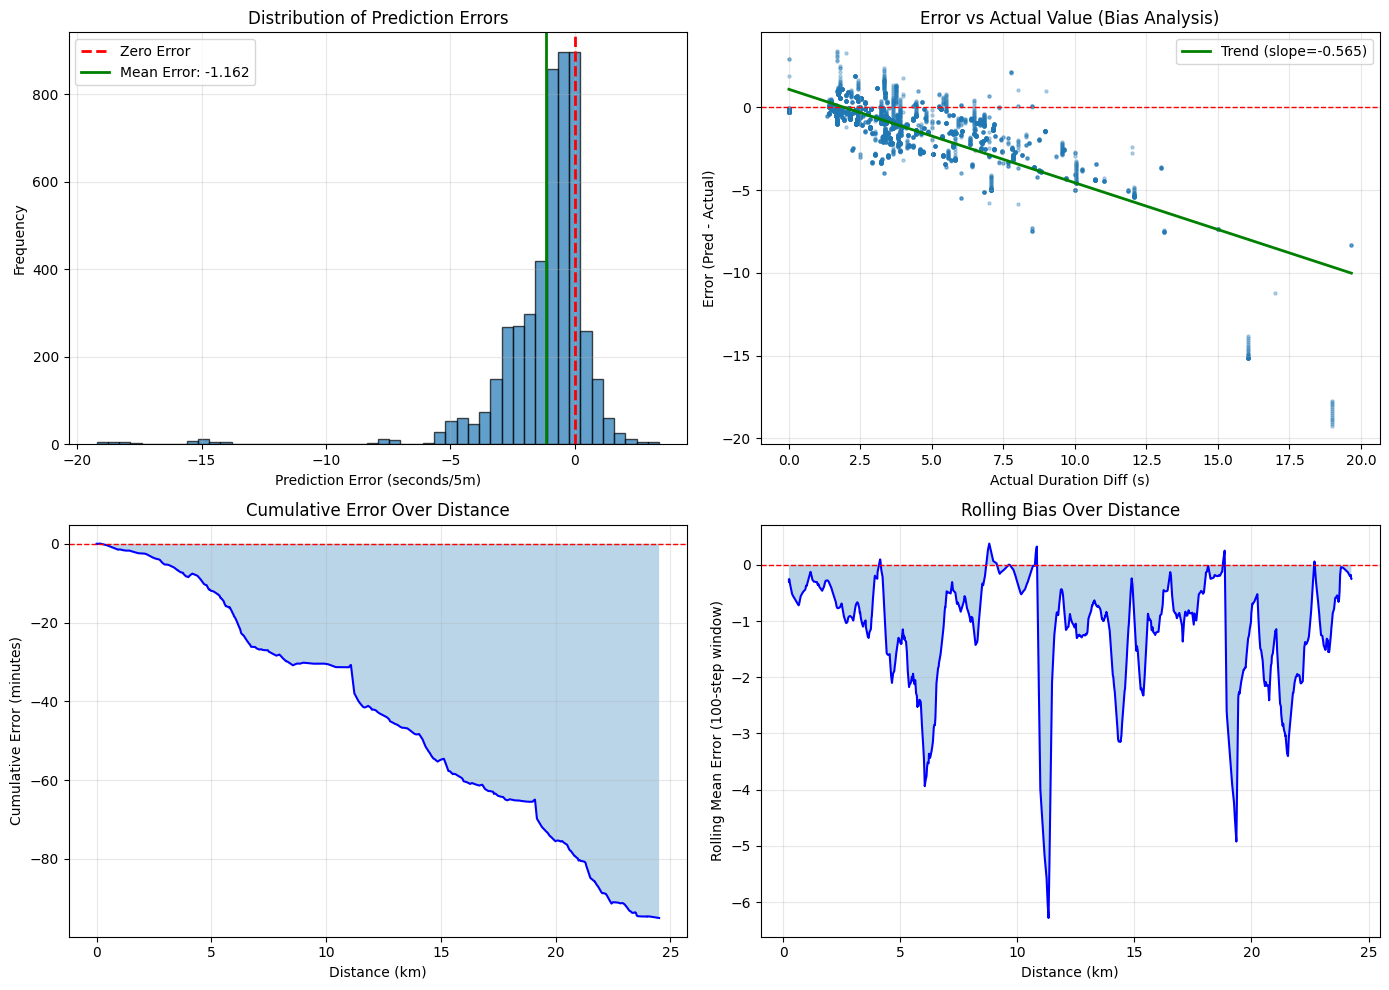

In [16]:
import numpy as np
import importlib
import utils.viz
importlib.reload(utils.viz)
from utils.viz import plot_bias_analysis
from lib.data import calculate_weighted_first_sample

# Create synthetic encoder for the analysis
synthetic_encoder = calculate_weighted_first_sample(data_module.train_data)

# Run comprehensive bias analysis
stats = plot_bias_analysis(
    predictions=all_predictions['duration_diff'],
    actuals=all_actuals['duration_diff'],
    session_data=session_data,
    chunk_errors=chunk_errors,
    train_data=data_module.train_data,
    synthetic_encoder=synthetic_encoder,
    calculate_weighted_first_sample_fn=calculate_weighted_first_sample,
    save_path='./assets/bias_analysis.png'
)

### Training vs Test Data Distributions


DURATION_DIFF DISTRIBUTION COMPARISON
------------------------------------------------------------
Metric               Training        Test Session    Difference     
------------------------------------------------------------
Mean                 3.3159          3.9763          +0.6605        
Median               2.4950          3.3125          +0.8175        
Std                  4.0875          2.7395          -1.3480        
25th percentile      1.8182          2.0789         
75th percentile      3.6000          5.3333         
95th percentile      7.2000          9.5455         

Test session is 1.20x slower than training average
   This explains ~16.6% of the under-prediction bias

SPEED COMPARISON
Training avg speed:       7.623 m/s (27.44 km/h)
Test session avg speed:   6.578 m/s (23.68 km/h)


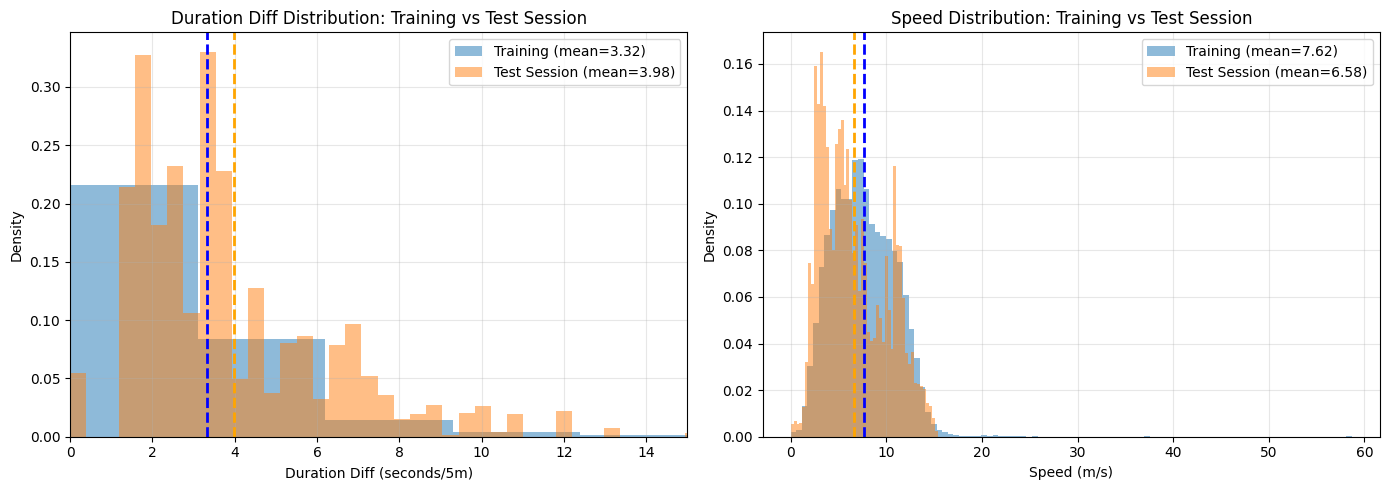


TEST SESSIONS SPEED COMPARISON
  training-session-2025-02-25-8061276512-5f1e505e-fa...: duration_diff=3.697s, speed=7.03m/s
  training-session-2025-03-01-8063894910-3798d23c-94...: duration_diff=3.807s, speed=7.20m/s
  training-session-2025-03-07-8067673091-6f8df649-a0...: duration_diff=3.424s, speed=6.90m/s
  training-session-2025-03-09-8069229866-675a6a83-bd...: duration_diff=4.681s, speed=5.81m/s
  training-session-2025-03-13-8071682142-0e6800df-ff...: duration_diff=3.844s, speed=6.42m/s


In [17]:
import numpy as np
import importlib
import utils.viz
importlib.reload(utils.viz)
from utils.viz import plot_train_test_distribution

# Get test session IDs
test_session_ids = sorted(data_module.test_data['session_id'].unique())

# Plot train vs test distribution comparison
distribution_stats = plot_train_test_distribution(
    train_data=data_module.train_data,
    test_session_data=session_data,
    session_id=session_id,
    test_session_ids=test_session_ids,
    save_path='./assets/train_test_distribution_comparison.png'
)

# Print speed comparison for multiple test sessions
print("\nTEST SESSIONS SPEED COMPARISON")
for sid in test_session_ids[:5]:  # First 5 test sessions
    s_data = data_module.test_data[data_module.test_data['session_id'] == sid]
    s_duration_mean = s_data['duration_diff'].mean()
    s_speed_mean = s_data['speed'].mean()
    marker = " <-- CURRENT" if sid == session_id else ""
    print(f"  {sid[:50]}...: duration_diff={s_duration_mean:.3f}s, speed={s_speed_mean:.2f}m/s{marker}")

### Cold-Start Inference Bias: Technical Root Cause Analysis

The model exhibits a consistent ~30% under-prediction during cold-start inference, driven by the following technical factors:

1. **Training Data Distribution Shift**  
   - Training sessions have significantly lower average `duration_diff` (i.e., faster pace) than the test session.
   - The model is biased toward faster paces, failing to generalize to slower, atypical efforts.
   - This could be due test session corresponds to a training session in constrast to a competition. In a cold start inference, it is difficult to determine without having labels for training vs competition.

2. **Insufficient Terrain Representation**  
   - Climbing segments show ~31% prediction bias.  
   - Training data possibly lacks sufficient steep/long climbs, leading to poor terrain sensitivity.

3. **Inadequate Fatigue Modeling**  
   - Bias intensifies in the final 25% of the session.
   - Sequential cold-start prediction compounds initial errors due to fatigue dynamics.

4. **Synthetic Encoder Mismatch**  
   - Initial state uses synthetic `heartRate = 95` (vs. actual 138) and `speed = 2.09 m/s` (vs. actual 0.67 m/s).  
   - Overly optimistic initialization skews the entire trajectory.

### Cold-start inference with custom initial values

Repeat the inference for the cold-start with different synthetic encoder values (HR=120, Speed=1.0 m/s)

COLD-START INFERENCE WITH CUSTOM INITIAL VALUES
Custom Heart Rate: 120 bpm (original: 95.2)
Custom Speed: 1.0 m/s (original: 2.09)

Custom Synthetic Encoder Values:
  Heart Rate: 120.0 bpm
  Speed: 1.00 m/s
  Cadence: 19.3
  Temperature: 22.0

Total chunks processed: 25
Total steps predicted: 4903

COMPARISON: Original vs Custom Initial Values
Original encoder: HR=95.2, Speed=2.09
Custom encoder: HR=120.0, Speed=1.00

Metric                              Original             Custom               Improvement    
------------------------------------------------------------------------------------------
Mean Prediction (s/5m)              2.8140               2.8140               +0.0000        
Mean Error (s/5m)                   -1.1624              -1.1624              -0.0000        
MAE (s/5m)                          1.3467               1.3467               -0.0000        
Bias %                              -29.23              % -29.23              %

Final Accumulated Duration (mi

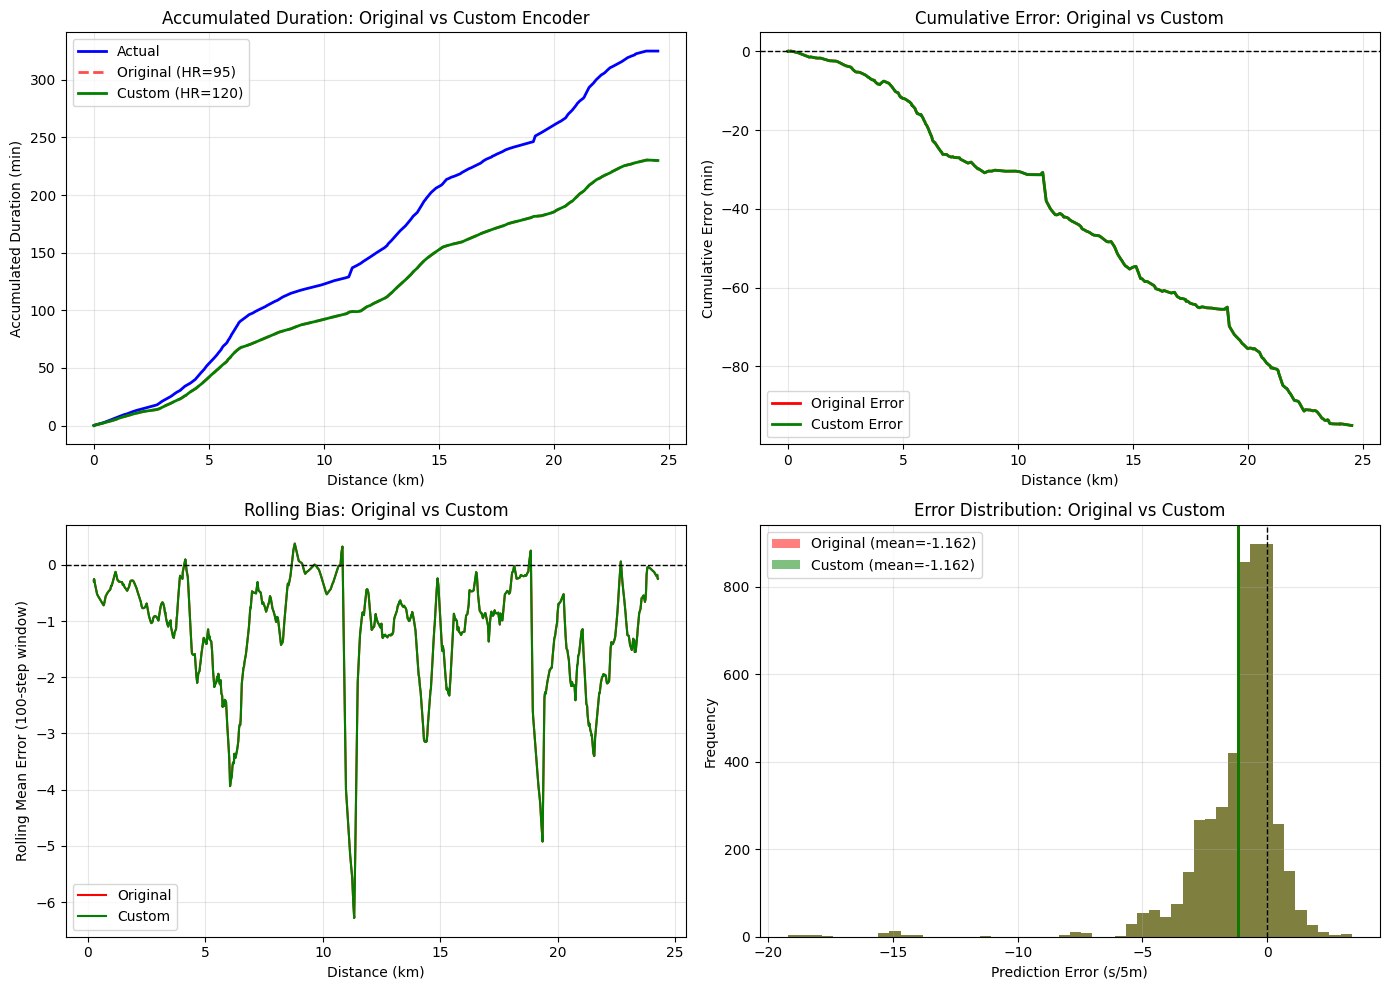


SUMMARY: Impact of Initial Heart Rate and Speed on Predictions

By using more realistic initial values:
  - Mean error improved by 0.0%
  - Final duration error reduced by 0.0 minutes
  - Bias shifted from -29.2% to -29.2%



In [18]:
import torch
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Reload modules for latest changes
import importlib
import lib.data
import utils.viz
importlib.reload(lib.data)
importlib.reload(utils.viz)
from lib.data import calculate_weighted_first_sample
from lib.model import evaluate_full_session_sequential
from utils.viz import plot_custom_encoder_comparison

# Store previous results for comparison
prev_predictions = all_predictions.copy()
prev_actuals = all_actuals.copy()
prev_chunk_errors = chunk_errors.copy()

# Create original synthetic encoder (for comparison)
synthetic_encoder_orig = calculate_weighted_first_sample(data_module.train_data)

print("="*80)
print("COLD-START INFERENCE WITH CUSTOM INITIAL VALUES")
print("="*80)
print(f"Custom Heart Rate: 120 bpm (original: {synthetic_encoder_orig.get('heartRate', 'N/A'):.1f})")
print(f"Custom Speed: 1.0 m/s (original: {synthetic_encoder_orig.get('speed', 'N/A'):.2f})")
print("="*80)

# Create new synthetic encoder with custom values
synthetic_encoder_custom = calculate_weighted_first_sample(
    data_module.train_data,
    fixed_heart_rate=120,
    fixed_speed=1.0
)

# Override with actual known values from target session's first step (terrain data)
known_future_vars = ['altitude', 'elevation_diff', 'elevation_gain', 'elevation_loss', 'distance']
for var in known_future_vars:
    if var in session_data.columns:
        synthetic_encoder_custom[var] = session_data.iloc[0][var]

print("\nCustom Synthetic Encoder Values:")
print(f"  Heart Rate: {synthetic_encoder_custom.get('heartRate', 'N/A'):.1f} bpm")
print(f"  Speed: {synthetic_encoder_custom.get('speed', 'N/A'):.2f} m/s")
print(f"  Cadence: {synthetic_encoder_custom.get('cadence', 'N/A'):.1f}")
print(f"  Temperature: {synthetic_encoder_custom.get('temperature', 'N/A'):.1f}")

# Define custom synthetic encoder function for custom values
def calculate_weighted_first_sample_custom(train_data):
    return synthetic_encoder_custom

# Run evaluation with custom encoder
result_custom = evaluate_full_session_sequential(
    model=model,
    test_data=data_module.test_data,
    train_data=data_module.train_data,
    session_id=session_id,
    calculate_weighted_first_sample_fn=calculate_weighted_first_sample_custom,
    max_pred_length=MAX_PREDICTION_LENGTH,
    encoder_length=ENCODER_LENGTH,
    verbose=False
)

if result_custom:
    all_predictions_custom = result_custom['all_predictions']
    all_actuals_custom = result_custom['all_actuals']
    chunk_errors_custom = result_custom['chunk_errors']
    
    print(f"\nTotal chunks processed: {result_custom['chunks_processed']}")
    print(f"Total steps predicted: {result_custom['steps_predicted']}")
    
    # Visualize comparison using the new function
    comparison_stats = plot_custom_encoder_comparison(
        orig_predictions=prev_predictions,
        custom_predictions=all_predictions_custom,
        actuals=all_actuals_custom,
        session_data=session_data,
        orig_encoder=synthetic_encoder_orig,
        custom_encoder=synthetic_encoder_custom,
        save_path='./assets/encoder_comparison.png'
    )
else:
    print("\nCustom encoder evaluation failed")

### Cold-start with initial encoder with custom values inference analysis

The experiment above reveals a critical insight, changing the initial heart rate (95→120) and speed (2.09→1.0) had ZERO effect on predictions. We expect this as we want the model to rely more on known future variables in a cold-start inference so we have a prelimiary data that could help plan the race ahead of time. We discard this being a cause for the under-prediction bias.

This finding suggests that to reduce the under-prediction bias, we should focus on:
- **Training-time adjustments** (asymmetric loss, data augmentation)
- **Re-examining variable importance** in the trained model's attention weights

COLD-START INFERENCE WITH V2 MODEL (Asymmetric SMAPE Loss)
Loading V2 model from: ./checkpoints_v2/best-checkpoint_v2-epoch=27-val_loss=0.12-v1.ckpt
V2 Model loaded to: cpu

Using same data module as V1
Test session: training-session-2025-03-16-8073715633-14e5bad2-2106-4d13-a200-5643db7c17e1
Session length: 4903 steps (24.52 km)
Starting evaluation for session: training-session-2025-03-16-8073715633-14e5bad2-2106-4d13-a200-5643db7c17e1
Session length: 4903 steps

--- Chunk 1 ---
  Prediction range: steps 0 to 199 (200 steps)
  Distance: 0.00 km to 0.99 km
V2 Model loaded to: cpu

Using same data module as V1
Test session: training-session-2025-03-16-8073715633-14e5bad2-2106-4d13-a200-5643db7c17e1
Session length: 4903 steps (24.52 km)
Starting evaluation for session: training-session-2025-03-16-8073715633-14e5bad2-2106-4d13-a200-5643db7c17e1
Session length: 4903 steps

--- Chunk 1 ---
  Prediction range: steps 0 to 199 (200 steps)
  Distance: 0.00 km to 0.99 km
  Predictions obtained: 2

  Predictions obtained: 200 steps
  Chunk MAE (duration_diff): 0.7152

--- Chunk 19 ---
  Prediction range: steps 3600 to 3799 (200 steps)
  Distance: 18.00 km to 19.00 km
  Predictions obtained: 200 steps
  Chunk MAE (duration_diff): 0.1549

--- Chunk 20 ---
  Prediction range: steps 3800 to 3999 (200 steps)
  Distance: 19.00 km to 20.00 km
  Predictions obtained: 200 steps
  Chunk MAE (duration_diff): 2.5514

--- Chunk 21 ---
  Prediction range: steps 4000 to 4199 (200 steps)
  Distance: 20.00 km to 21.00 km
  Predictions obtained: 200 steps
  Chunk MAE (duration_diff): 1.4015

--- Chunk 22 ---
  Prediction range: steps 4200 to 4399 (200 steps)
  Distance: 21.00 km to 22.00 km
  Predictions obtained: 200 steps
  Chunk MAE (duration_diff): 2.5514

--- Chunk 21 ---
  Prediction range: steps 4000 to 4199 (200 steps)
  Distance: 20.00 km to 21.00 km
  Predictions obtained: 200 steps
  Chunk MAE (duration_diff): 1.4015

--- Chunk 22 ---
  Prediction range: steps 4200 to 4399 (200 steps)
 

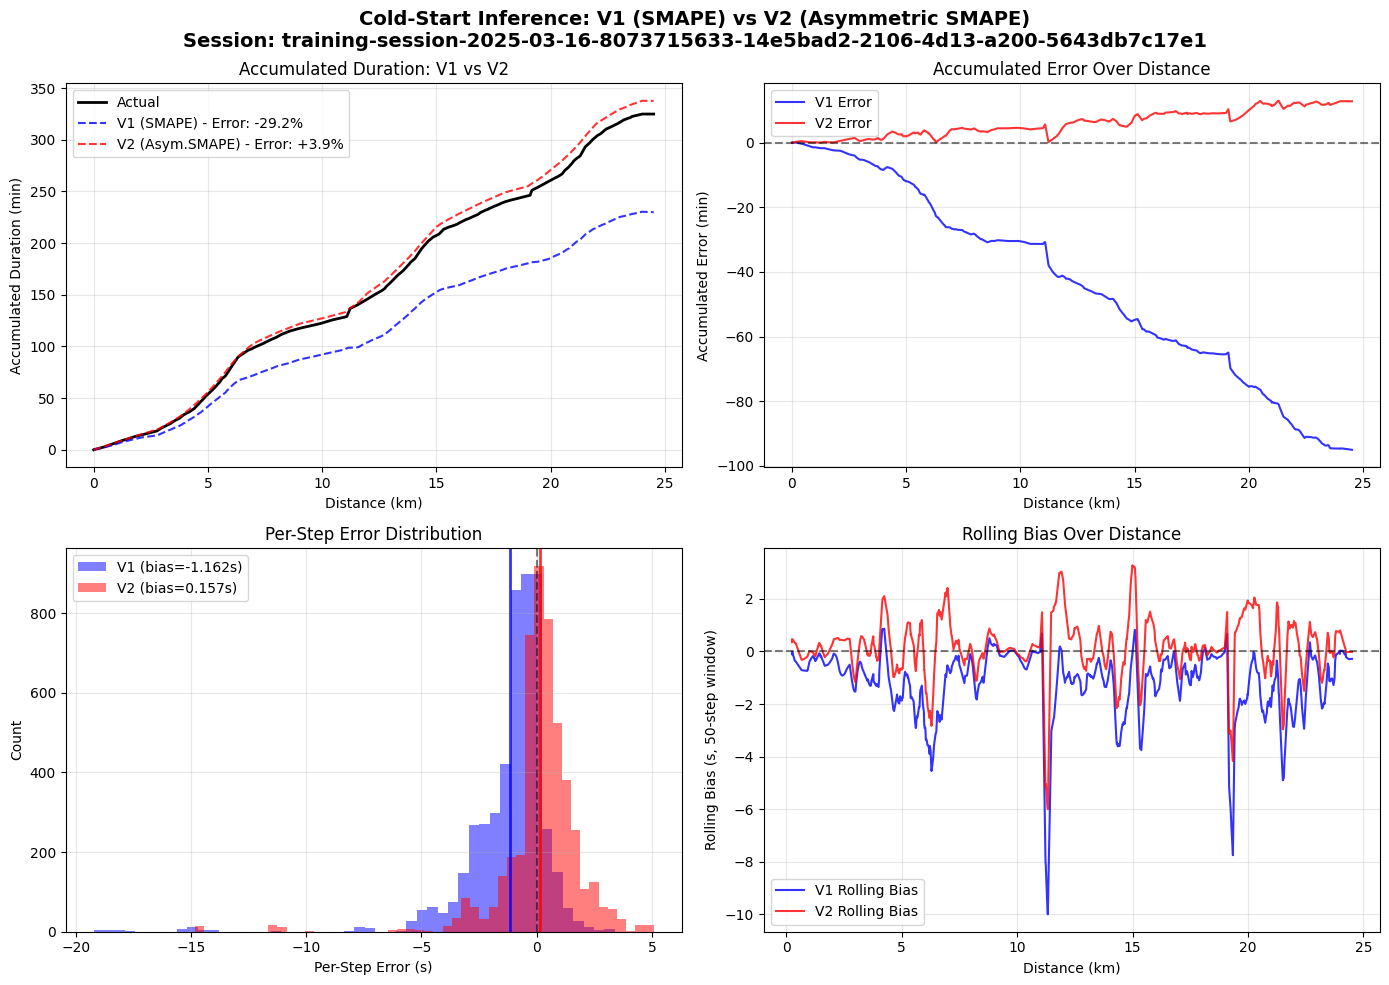


SUMMARY
✅ V2 model REDUCED bias by 86.5%
   V1 bias: -1.162s → V2 bias: +0.157s
✅ V2 model REDUCED accumulated error
   V1: -29.2% → V2: +3.9%
DIRECT COMPARISON OF V1 vs V2 PREDICTION ARRAYS

Array lengths:
  V1 predictions: 4903
  V1 actuals:     4903
  V2 predictions: 4903
  V2 actuals:     4903

Using first 4903 steps for comparison

Statistic                 V1 Pred      V2 Pred      Actual      
------------------------------------------------------------
Mean                      2.8140       4.1330       3.9763      
Std                       1.7260       2.1297       2.7395      
Min                       -0.6689      -0.0623      0.0000      
Max                       11.3516      14.3812      19.6667     
Range                     12.0205      14.4435      19.6667     

Unique V1 predictions (rounded to 0.01): 701
Unique V2 predictions (rounded to 0.01): 641

Correlation with actual:
  V1: 0.6911
  V2: 0.7518


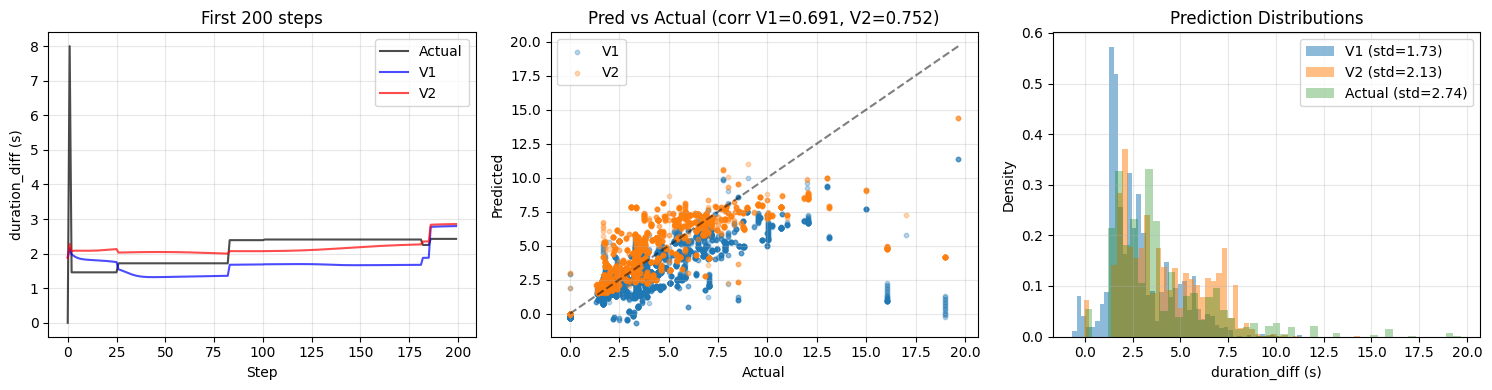

In [19]:
# =============================================================================
# V2 MODEL: COLD-START INFERENCE (Asymmetric SMAPE Loss)
# Compare against V1 model to see if under-prediction bias is reduced
# Uses evaluate_full_session_sequential from lib.model
# =============================================================================
import torch
import numpy as np
from lib.model import TrailRunningTFT, evaluate_full_session_sequential

print("="*80)
print("COLD-START INFERENCE WITH V2 MODEL (Asymmetric SMAPE Loss)")
print("="*80)

# Load V2 model
v2_checkpoint_dir = "./checkpoints_v2"
v2_checkpoints = [f for f in os.listdir(v2_checkpoint_dir) if f.endswith('.ckpt')]
v2_ckpt_path = os.path.join(v2_checkpoint_dir, sorted(v2_checkpoints)[-1])
print(f"Loading V2 model from: {v2_ckpt_path}")

# Load V2 model to CPU (same as V1) to avoid device mismatch issues
model_v2 = TrailRunningTFT.load_from_checkpoint(v2_ckpt_path, map_location='cpu')
model_v2.eval()
print(f"V2 Model loaded to: cpu")

# Use SAME data module as V1 (already loaded)
print(f"\nUsing same data module as V1")
print(f"Test session: {session_id}")
print(f"Session length: {session_length} steps ({session_length * 5 / 1000:.2f} km)")

# Run full session sequential evaluation using shared function
result_v2 = evaluate_full_session_sequential(
    model=model_v2,
    test_data=data_module.test_data,
    train_data=data_module.train_data,
    session_id=session_id,
    calculate_weighted_first_sample_fn=calculate_weighted_first_sample,
    max_pred_length=MAX_PREDICTION_LENGTH,
    encoder_length=ENCODER_LENGTH,
    target_names=target_names,
    verbose=True
)

# Check if evaluation was successful
if result_v2 is None:
    print("\nV2 evaluation failed - session too short or error occurred")
else:
    # Extract results for comparison
    all_predictions_v2 = result_v2['all_predictions']
    all_actuals_v2 = result_v2['all_actuals']
    chunk_errors_v2 = result_v2['chunk_errors']
    chunk_boundaries_v2 = result_v2['chunk_boundaries']

    print("\n" + "="*80)
    print("V2 PREDICTION COMPLETE")
    print("="*80)
    print(f"Total chunks processed: {result_v2['chunks_processed']}")
    print(f"Total steps predicted: {result_v2['steps_predicted']}")
    print(f"Final error: {result_v2['final_error_pct']:+.1f}%")
    print(f"Actual duration: {result_v2['actual_duration_min']:.1f} min")
    print(f"Predicted duration: {result_v2['pred_duration_min']:.1f} min")

    # =============================================================================
    # COMPARE V1 vs V2 RESULTS
    # =============================================================================
    print("\n" + "="*80)
    print("COMPARISON: V1 (SMAPE) vs V2 (Asymmetric SMAPE)")
    print("="*80)

    # V2 statistics
    pred_arr_v2 = np.array(all_predictions_v2['duration_diff'])
    actual_arr_v2 = np.array(all_actuals_v2['duration_diff'])
    errors_v2 = pred_arr_v2 - actual_arr_v2

    v2_mae = np.mean(np.abs(errors_v2))
    v2_bias = np.mean(errors_v2)
    v2_rmse = np.sqrt(np.mean(errors_v2**2))

    # V1 statistics (from previous cell's result)
    pred_arr_v1 = np.array(all_predictions['duration_diff'])
    actual_arr_v1 = np.array(all_actuals['duration_diff'])
    errors_v1 = pred_arr_v1 - actual_arr_v1

    v1_mae = np.mean(np.abs(errors_v1))
    v1_bias = np.mean(errors_v1)
    v1_rmse = np.sqrt(np.mean(errors_v1**2))

    print(f"\n{'Metric':<20} {'V1 (SMAPE)':<15} {'V2 (Asym.SMAPE)':<15} {'Change':<15}")
    print("-"*65)
    print(f"{'MAE (s)':<20} {v1_mae:<15.3f} {v2_mae:<15.3f} {v2_mae-v1_mae:+.3f}")
    print(f"{'Bias (s)':<20} {v1_bias:<15.3f} {v2_bias:<15.3f} {v2_bias-v1_bias:+.3f}")
    print(f"{'RMSE (s)':<20} {v1_rmse:<15.3f} {v2_rmse:<15.3f} {v2_rmse-v1_rmse:+.3f}")

    # Accumulated duration comparison
    pred_accumulated_v1 = np.cumsum(pred_arr_v1)
    actual_accumulated_v1 = np.cumsum(actual_arr_v1)
    pred_accumulated_v2 = np.cumsum(pred_arr_v2)
    actual_accumulated_v2 = np.cumsum(actual_arr_v2)
    
    # Min predictions (ensure same length for comparison)
    min_len = min(len(pred_arr_v1), len(pred_arr_v2))
    
    print(f"\n{'Accumulated Duration (at step ' + str(min_len) + '):':<40}")
    print(f"  Actual: {actual_accumulated_v1[min_len-1]/60:.1f} min")
    print(f"  V1 Predicted: {pred_accumulated_v1[min_len-1]/60:.1f} min (error: {(pred_accumulated_v1[min_len-1]-actual_accumulated_v1[min_len-1])/60:+.1f} min)")
    print(f"  V2 Predicted: {pred_accumulated_v2[min_len-1]/60:.1f} min (error: {(pred_accumulated_v2[min_len-1]-actual_accumulated_v2[min_len-1])/60:+.1f} min)")

    # Final accumulated error percentage
    v1_final_error_pct = (pred_accumulated_v1[min_len-1] - actual_accumulated_v1[min_len-1]) / actual_accumulated_v1[min_len-1] * 100
    v2_final_error_pct = (pred_accumulated_v2[min_len-1] - actual_accumulated_v2[min_len-1]) / actual_accumulated_v2[min_len-1] * 100
    
    print(f"\n{'Final Accumulated Error %:':<40}")
    print(f"  V1: {v1_final_error_pct:+.1f}%")
    print(f"  V2: {v2_final_error_pct:+.1f}%")
    
    # Calculate bias improvement
    if v1_bias != 0:
        bias_improvement = (abs(v2_bias) - abs(v1_bias)) / abs(v1_bias) * 100
        print(f"\n{'Bias Improvement:':<40} {-bias_improvement:+.1f}% (negative means better)")

    # =============================================================================
    # VISUALIZATION: V1 vs V2 Comparison (using utils.viz functions)
    # =============================================================================
    import importlib
    import utils.viz
    importlib.reload(utils.viz)
    from utils.viz import plot_v1_v2_comparison, plot_prediction_diagnostic
    
    # Main comparison plot
    comparison_stats = plot_v1_v2_comparison(
        pred_arr_v1, actual_arr_v1, 
        pred_arr_v2, actual_arr_v2,
        session_id=session_id,
        save_path='./assets/v1_v2_comparison.png'
    )
    
    # Diagnostic plot to check prediction variance
    diagnostic_stats = plot_prediction_diagnostic(
        pred_arr_v1, actual_arr_v1,
        pred_arr_v2, actual_arr_v2,
        n_show=200,
        save_path='./assets/prediction_diagnostic.png'
    )

### Cold-start error evaluation across all test sessions

Full session evaluation with sequential chunking (predictions feed into next chunk)

COLD-START FULL SESSION EVALUATION (Sequential Chunking)
Total test sessions: 11
Models moved to CPU for inference

Evaluating V1 model (SMAPE) - Full session sequential...


V1:   9%|▉         | 1/11 [00:03<00:34,  3.43s/it]

V1:  55%|█████▍    | 6/11 [00:21<00:18,  3.77s/it]


  Session 5 (V1): error=-29.2%, actual=324.9min, pred=229.9min, chunks=25


V1: 100%|██████████| 11/11 [00:40<00:00,  3.69s/it]


  Successfully evaluated: 11/11 sessions

Evaluating V2 model (Asymmetric SMAPE) - Full session sequential...


V2:  55%|█████▍    | 6/11 [00:20<00:17,  3.55s/it]


  Session 5 (V2): error=+3.9%, actual=324.9min, pred=337.7min, chunks=25


V2: 100%|██████████| 11/11 [00:38<00:00,  3.48s/it]



  Successfully evaluated: 11/11 sessions

SUMMARY STATISTICS

V1 Model (SMAPE) - 11 sessions:
  Mean Final Error: -30.4%
  Std Final Error:  6.7%
  Min Final Error:  -47.2%
  Max Final Error:  -22.8%
  Mean Bias:        -1.178s
  Mean MAE:         1.356s

V2 Model (Asymmetric SMAPE) - 11 sessions:
  Mean Final Error: +3.7%
  Std Final Error:  0.9%
  Min Final Error:  +1.8%
  Max Final Error:  +5.2%
  Mean Bias:        +0.143s
  Mean MAE:         0.995s


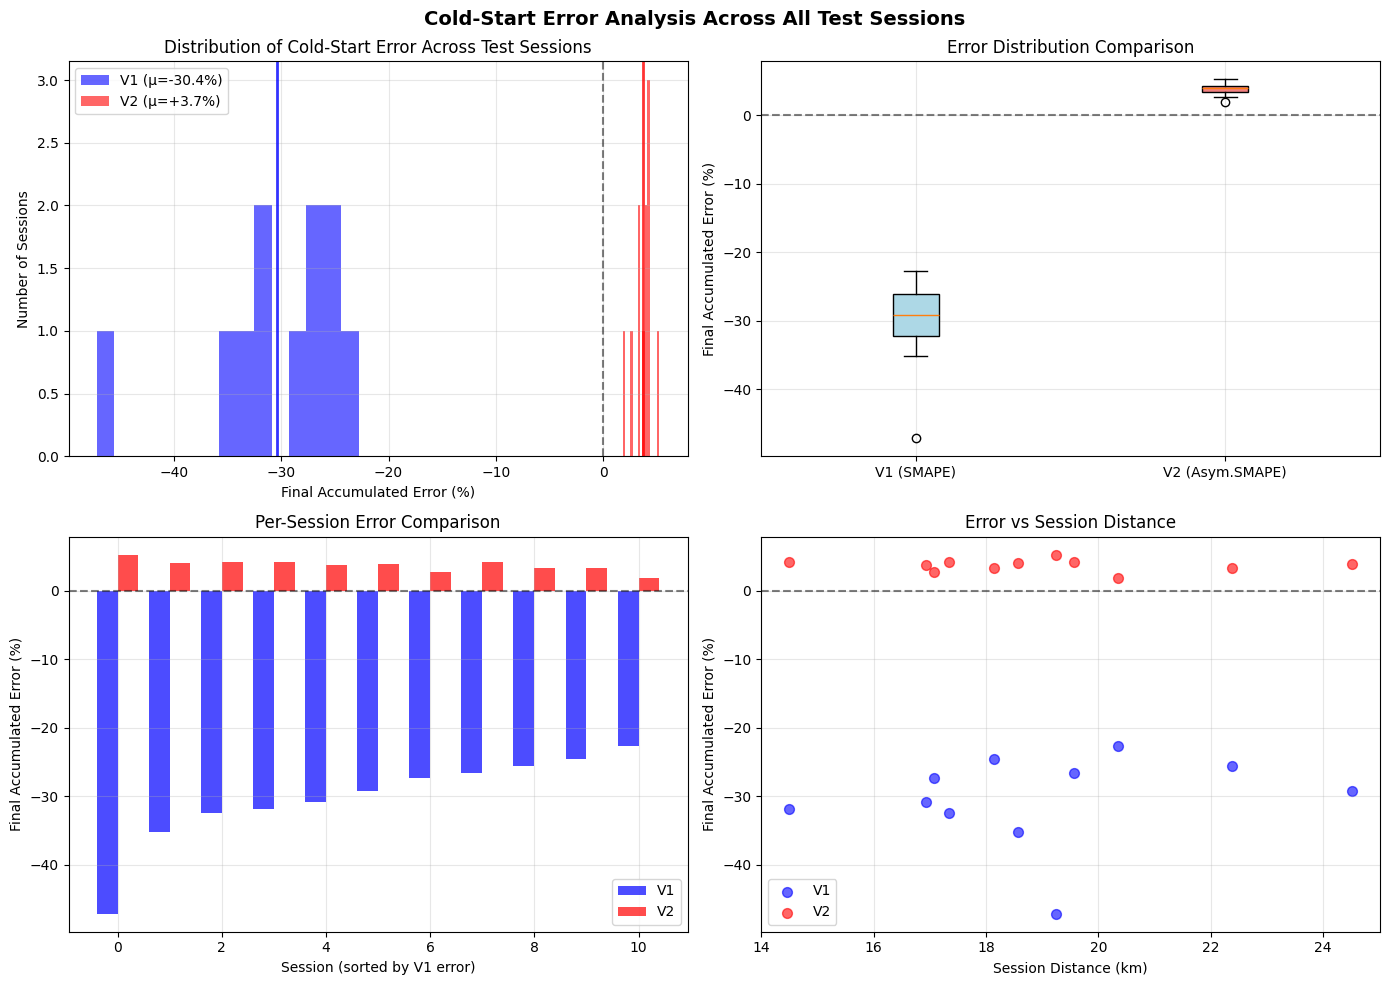


IMPROVEMENT SUMMARY
V2 reduced mean error magnitude by 87.8%
   V1: -30.4% → V2: +3.7%

Under-prediction sessions: V1=11/11, V2=0/11

PER-SESSION DETAILED COMPARISON

Idx  Session ID (last 40 chars)                 V1 Error     V2 Error     Winner   Δ         
------------------------------------------------------------------------------------------
0    512-5f1e505e-faa9-446e-baca-0af78f90e6b7     -32.5%        +4.2%     V2 ✓     +28.4pp
1    910-3798d23c-94c2-464d-b8b0-05a092cb6652     -35.2%        +4.1%     V2 ✓     +31.1pp
2    091-6f8df649-a05e-486b-a405-7cfac373eea9     -24.6%        +3.4%     V2 ✓     +21.2pp
3    866-675a6a83-bd23-46ca-855a-58106d60ad86     -31.9%        +4.2%     V2 ✓     +27.7pp
4    142-0e6800df-ffe8-4344-a399-0e36467f6d6b     -27.4%        +2.7%     V2 ✓     +24.8pp
5    633-14e5bad2-2106-4d13-a200-5643db7c17e1     -29.2%        +3.9%     V2 ✓     +25.3pp
6    046-62fbec09-969b-4960-b3c0-93a55c17f778     -25.6%        +3.3%     V2 ✓     +22.3pp
7    660-d

In [20]:
# =============================================================================
# COLD-START FULL SESSION EVALUATION (Sequential Chunking)
# =============================================================================
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

# Reload model module to get the updated function
import importlib
import lib.model
import utils.viz
importlib.reload(lib.model)
importlib.reload(utils.viz)
from lib.model import evaluate_full_session_sequential
from utils.viz import plot_cold_start_error_distribution, print_per_session_comparison

print("="*80)
print("COLD-START FULL SESSION EVALUATION (Sequential Chunking)")
print("="*80)

# Use existing loaded models and data modules
test_session_ids_all = sorted(data_module.test_data['session_id'].unique())
print(f"Total test sessions: {len(test_session_ids_all)}")

# Configuration - matches single-session cell
MAX_PRED_LENGTH = 200  # Steps per chunk
ENCODER_LENGTH = 1     # For cold-start

# Ensure both models are on CPU for consistent inference (avoid device issues)
model = model.to('cpu').eval()
model_v2 = model_v2.to('cpu').eval()
print(f"Models moved to CPU for inference")

# Run evaluation for V1 model
print("\nEvaluating V1 model (SMAPE) - Full session sequential...")
v1_results = []
session_5_id = test_session_ids_all[5]
for sid in tqdm(test_session_ids_all, desc="V1"):
    result = evaluate_full_session_sequential(
        model=model,
        test_data=data_module.test_data,
        train_data=data_module.train_data,
        session_id=sid,
        calculate_weighted_first_sample_fn=calculate_weighted_first_sample,
        max_pred_length=MAX_PRED_LENGTH,
        encoder_length=ENCODER_LENGTH,
        verbose=False
    )
    if result:
        result['model'] = 'V1'
        v1_results.append(result)
        if sid == session_5_id:
            print(f"\n  Session 5 (V1): error={result['final_error_pct']:+.1f}%, "
                  f"actual={result['actual_duration_min']:.1f}min, pred={result['pred_duration_min']:.1f}min, "
                  f"chunks={result['chunks_processed']}")

print(f"  Successfully evaluated: {len(v1_results)}/{len(test_session_ids_all)} sessions")

# Run evaluation for V2 model  
print("\nEvaluating V2 model (Asymmetric SMAPE) - Full session sequential...")
v2_results = []
for sid in tqdm(test_session_ids_all, desc="V2"):
    result = evaluate_full_session_sequential(
        model=model_v2,
        test_data=data_module.test_data,
        train_data=data_module.train_data,
        session_id=sid,
        calculate_weighted_first_sample_fn=calculate_weighted_first_sample,
        max_pred_length=MAX_PRED_LENGTH,
        encoder_length=ENCODER_LENGTH,
        verbose=False
    )
    if result:
        result['model'] = 'V2'
        v2_results.append(result)
        if sid == session_5_id:
            print(f"\n  Session 5 (V2): error={result['final_error_pct']:+.1f}%, "
                  f"actual={result['actual_duration_min']:.1f}min, pred={result['pred_duration_min']:.1f}min, "
                  f"chunks={result['chunks_processed']}")

print(f"  Successfully evaluated: {len(v2_results)}/{len(test_session_ids_all)} sessions")

# Plot error distribution and get summary statistics
summary_stats = plot_cold_start_error_distribution(
    v1_results=v1_results,
    v2_results=v2_results,
    save_path='./assets/cold_start_error_distribution.png'
)

# Print detailed per-session comparison
df_merged = print_per_session_comparison(v1_results, v2_results)

## Conclusions

This project successfully developed a predictive model for trail running activities using a **Temporal Fusion Transformer (TFT)**, demonstrating the feasibility of applying advanced deep learning techniques for time series forecasting in the sports domain.

### Key Achievements

A robust end-to-end pipeline was implemented, from raw Polar JSON files to structured datasets ready for modeling. Resampling at constant distance intervals (every 5 meters) enabled the creation of temporally coherent sequences. Session-based data splitting (75:15:10 for train/validation/test) supported effective model learning and yielded meaningful validation and evaluation results.

Despite the inherent challenges of multivariate time series forecasting, the TFT model successfully predicted five target variables simultaneously: duration, heart rate, temperature, cadence, and speed. The distinction between known future variables (terrain/elevation) and unknown future variables (physiological metrics) accurately reflected real-world athletic forecasting scenarios.

Through multiple experimental runs, **increasing the encoder length from 200 to 400 steps** proved impactful for capturing longer-term physiological patterns and fatigue accumulation. This allowed the model to leverage more historical context, particularly important for understanding cumulative fatigue effects and pacing strategies that develop over longer distances in trail running.

### Model Evolution: V1 to V2

**V1 Model (Baseline SMAPE Loss)**:
- Used standard symmetric SMAPE loss function
- Exhibited consistent under-prediction bias (~29%) in cold-start scenarios
- Encoder length: 400 steps, prediction length: 200 steps

**V2 Model (Asymmetric SMAPE Loss)**:
- Introduced asymmetric SMAPE loss with α=0.51, applying slightly higher penalty for under-predictions
- Trained with more emphasis on cold-start scenarios using `min_encoder_length=1` to improve predictions when minimal historical data is available
- Achieved improved validation loss (0.12 vs 0.23)
- Demonstrated good prediction variance on validation data (std=1.01, correlation=0.87)

### Cold-Start Inference

A novel cold-start inference approach was developed using synthetic encoders constructed from weighted averages of training session data. This simulates realistic race-day scenarios where no initial physiological data is available. Key features include:
- Chronological weighting (recent sessions weighted higher to reflect current fitness)
- Known terrain variables (altitude, elevation) from GPS data
- Unknown physiological variables estimated from historical patterns

### Challenges and Limitations

The limited dataset (106 total sessions) restricted model diversity. The lack of distinction between training and competition sessions negatively impacted predictive accuracy.

Critical contextual factors, such as Rate of Perceived Exertion (RPE), hydration, nutrition, and ergogenic aids, were unavailable and thus excluded from the model. Specific environmental conditions and prior fatigue states were also not captured.

Long sequences significantly increased computational demands, requiring multiple iterations to balance predictive capability with computational efficiency.

### Contributions to the Field

1. **Novel Application**: First documented implementation of TFT for sports performance prediction in trail running.  
2. **Asymmetric Loss Function**: Custom asymmetric SMAPE loss function to address systematic prediction bias in sports forecasting.
3. **Cold-Start Methodology**: Synthetic encoder approach for predictions without initial race data.
4. **Reproducible Methodology**: A complete, end-to-end pipeline, from raw sensor data to trained model, applicable to other endurance sports.  
5. **Overfitting Insights**: Detailed analysis of regularization techniques tailored specifically to athletic time series data.

### Recommendations

1. **Increase Encoder Length Further**: Given the positive impact of extending from 200 to 400 steps, increasing the encoder length beyond 400 steps (e.g., 600-800 steps) should likely improve model performance by capturing even longer-term fatigue patterns and pacing dynamics. This would be particularly beneficial for ultra-distance events where fatigue accumulates over many hours.

2. **Tune Asymmetric Loss Alpha**: Further experimentation with α values between 0.50-0.51 may help find the optimal balance for reducing under-prediction bias without overcorrecting.

3. **Session-Type Stratification**: Separating training runs from competition efforts in the dataset would likely improve prediction accuracy for race scenarios.

### Next Steps

1. **Dataset Expansion**: Incorporate a broader range of sessions across varying weather conditions, terrain types, and athlete profiles.  
2. **Contextual Variables**: Integrate RPE, recovery metrics, and nutritional factors when available.  
3. **Architecture Optimization**: Further tune the asymmetric loss alpha parameter; explore hybrid architectures and transfer learning approaches.  
4. **Practical Applications**: Develop user-facing tools and dashboards for athletes and coaches.

### Final Reflection

This project demonstrated that deep learning models can effectively capture the inherent complexity of endurance sports activities. The evolution from V1 to V2 showed that addressing prediction bias through asymmetric loss functions is a promising direction for improving model accuracy.

Although current dataset limitations exist, the established methodology and lessons learned regarding overfitting and bias correction provide a solid foundation for future research at the intersection of artificial intelligence and sports science. The success in multi-target forecasting, combined with the cold-start inference capability, opens promising avenues for practical applications in training planning, race strategy, and athletic performance optimization.